In [5]:
# Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/blob/master/unsupervised_class3/
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import imageio as im
from datetime import datetime

In [6]:
LEARNING_RATE = 0.0002
BETA1 = 0.5
BATCH_SIZE = 64
EPOCHS = 2
SAVE_SAMPLE_PERIOD = 50

In [7]:
def lrelu(x, alpha=0.2):
  return tf.maximum(alpha*x, x)

def get_mnist(limit=None):
  print("Reading in and transforming data...")
  df = pd.read_csv('large_files/train.csv')
  data = df.values
  # np.random.shuffle(data)
  X = data[:, 1:] / 255.0 # data is from 0..255
  Y = data[:, 0]
  X, Y = shuffle(X, Y)
  if limit is not None:
    X, Y = X[:limit], Y[:limit]
  return X, Y

In [8]:
class ConvLayer:
  def __init__(self, name, mi, mo, apply_batch_norm, filtersz=5, stride=2, f=tf.nn.relu):
    # mi = input feature map size
    # mo = output feature map size
    # self.W = tf.Variable(0.02*tf.random_normal(shape=(filtersz, filtersz, mi, mo)))
    # self.b = tf.Variable(np.zeros(mo, dtype=np.float32))
    self.W = tf.get_variable(
      "W_%s" % name,
      shape=(filtersz, filtersz, mi, mo),
      # initializer=tf.contrib.layers.xavier_initializer(),
      initializer=tf.truncated_normal_initializer(stddev=0.02),
    )
    self.b = tf.get_variable(
      "b_%s" % name,
      shape=(mo,),
      initializer=tf.zeros_initializer(),
    )
    self.name = name
    self.f = f
    self.stride = stride
    self.apply_batch_norm = apply_batch_norm
    self.params = [self.W, self.b]

  def forward(self, X, reuse, is_training):
    # print("**************** reuse:", reuse)
    conv_out = tf.nn.conv2d(
      X,
      self.W,
      strides=[1, self.stride, self.stride, 1],
      padding='SAME'
    )
    conv_out = tf.nn.bias_add(conv_out, self.b)

    # apply batch normalization
    if self.apply_batch_norm:
      conv_out = tf.contrib.layers.batch_norm(
        conv_out,
        decay=0.9, 
        updates_collections=None,
        epsilon=1e-5,
        scale=True,
        is_training=is_training,
        reuse=reuse,
        scope=self.name,
      )
    return self.f(conv_out)


In [9]:
class FractionallyStridedConvLayer:
  def __init__(self, name, mi, mo, output_shape, apply_batch_norm, filtersz=5, stride=2, f=tf.nn.relu):
    # mi = input feature map size
    # mo = output feature map size
    # NOTE!!! shape is specified in the OPPOSITE way from regular conv
    # self.W = tf.Variable(0.02*tf.random_normal(shape=(filtersz, filtersz, mo, mi)))
    # self.b = tf.Variable(np.zeros(mo, dtype=np.float32))
    self.W = tf.get_variable(
      "W_%s" % name,
      shape=(filtersz, filtersz, mo, mi),
      # initializer=tf.contrib.layers.xavier_initializer(),
      initializer=tf.random_normal_initializer(stddev=0.02),
    )
    self.b = tf.get_variable(
      "b_%s" % name,
      shape=(mo,),
      initializer=tf.zeros_initializer(),
    )
    self.f = f
    self.stride = stride
    self.name = name
    self.output_shape = output_shape
    self.apply_batch_norm = apply_batch_norm
    self.params = [self.W, self.b]

  def forward(self, X, reuse, is_training):
    conv_out = tf.nn.conv2d_transpose(
      value=X,
      filter=self.W,
      output_shape=self.output_shape,
      strides=[1, self.stride, self.stride, 1],
    )
    conv_out = tf.nn.bias_add(conv_out, self.b)

    # apply batch normalization
    if self.apply_batch_norm:
      conv_out = tf.contrib.layers.batch_norm(
        conv_out,
        decay=0.9, 
        updates_collections=None,
        epsilon=1e-5,
        scale=True,
        is_training=is_training,
        reuse=reuse,
        scope=self.name,
      )

    return self.f(conv_out)

In [10]:
class DenseLayer(object):
  def __init__(self, name, M1, M2, apply_batch_norm, f=tf.nn.relu):
    self.W = tf.get_variable(
      "W_%s" % name,
      shape=(M1, M2),
      initializer=tf.random_normal_initializer(stddev=0.02),
    )
    self.b = tf.get_variable(
      "b_%s" % name,
      shape=(M2,),
      initializer=tf.zeros_initializer(),
    )
    self.f = f
    self.name = name
    self.apply_batch_norm = apply_batch_norm
    self.params = [self.W, self.b]

  def forward(self, X, reuse, is_training):
    a = tf.matmul(X, self.W) + self.b

    # apply batch normalization
    if self.apply_batch_norm:
      a = tf.contrib.layers.batch_norm(
        a,
        decay=0.9, 
        updates_collections=None,
        epsilon=1e-5,
        scale=True,
        is_training=is_training,
        reuse=reuse,
        scope=self.name,
      )
    return self.f(a)

In [11]:
class DCGAN:
  def __init__(self, img_length, num_colors, d_sizes, g_sizes):

    # save for later
    self.img_length = img_length
    self.num_colors = num_colors
    self.latent_dims = g_sizes['z']

    # define the input data
    self.X = tf.placeholder(
      tf.float32,
      shape=(None, img_length, img_length, num_colors),
      name='X'
    )
    self.Z = tf.placeholder(
      tf.float32,
      shape=(None, self.latent_dims),
      name='Z'
    )

    # note: by making batch_sz a placeholder, we can specify a variable
    # number of samples in the FS-conv operation where we are required
    # to pass in output_shape
    # we need only pass in the batch size via feed_dict
    self.batch_sz = tf.placeholder(tf.int32, shape=(), name='batch_sz')

    # build the discriminator
    logits = self.build_discriminator(self.X, d_sizes)

    # build generator
    self.sample_images = self.build_generator(self.Z, g_sizes)

    # get sample logits
    with tf.variable_scope("discriminator") as scope:
      scope.reuse_variables()
      sample_logits = self.d_forward(self.sample_images, True)

    # get sample images for test time (batch norm is different)
    with tf.variable_scope("generator") as scope:
      scope.reuse_variables()
      self.sample_images_test = self.g_forward(
        self.Z, reuse=True, is_training=False
      )

    # build costs
    self.d_cost_real = tf.nn.sigmoid_cross_entropy_with_logits(
      logits=logits,
      labels=tf.ones_like(logits)
    )
    self.d_cost_fake = tf.nn.sigmoid_cross_entropy_with_logits(
      logits=sample_logits,
      labels=tf.zeros_like(sample_logits)
    )
    self.d_cost = tf.reduce_mean(self.d_cost_real) + tf.reduce_mean(self.d_cost_fake)
    self.g_cost = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
        logits=sample_logits,
        labels=tf.ones_like(sample_logits)
      )
    )
    real_predictions = tf.cast(logits > 0, tf.float32)
    fake_predictions = tf.cast(sample_logits < 0, tf.float32)
    num_predictions = 2.0*BATCH_SIZE
    num_correct = tf.reduce_sum(real_predictions) + tf.reduce_sum(fake_predictions)
    self.d_accuracy = num_correct / num_predictions


    # optimizers
    self.d_params = [t for t in tf.trainable_variables() if t.name.startswith('d')]
    self.g_params = [t for t in tf.trainable_variables() if t.name.startswith('g')]

    self.d_train_op = tf.train.AdamOptimizer(
      LEARNING_RATE, beta1=BETA1
    ).minimize(
      self.d_cost, var_list=self.d_params
    )
    self.g_train_op = tf.train.AdamOptimizer(
      LEARNING_RATE, beta1=BETA1
    ).minimize(
      self.g_cost, var_list=self.g_params
    )

    # show_all_variables()
    # exit()

    # set up session and variables for later
    self.init_op = tf.global_variables_initializer()
    self.sess = tf.InteractiveSession()
    self.sess.run(self.init_op)


  def build_discriminator(self, X, d_sizes):
    with tf.variable_scope("discriminator") as scope:

      # build conv layers
      self.d_convlayers = []
      mi = self.num_colors
      dim = self.img_length
      count = 0
      for mo, filtersz, stride, apply_batch_norm in d_sizes['conv_layers']:
        # make up a name - used for get_variable
        name = "convlayer_%s" % count
        count += 1

        layer = ConvLayer(name, mi, mo, apply_batch_norm, filtersz, stride, lrelu)
        self.d_convlayers.append(layer)
        mi = mo
        print("dim:", dim)
        dim = int(np.ceil(float(dim) / stride))


      mi = mi * dim * dim
      # build dense layers
      self.d_denselayers = []
      for mo, apply_batch_norm in d_sizes['dense_layers']:
        name = "denselayer_%s" % count
        count += 1

        layer = DenseLayer(name, mi, mo, apply_batch_norm, lrelu)
        mi = mo
        self.d_denselayers.append(layer)


      # final logistic layer
      name = "denselayer_%s" % count
      self.d_finallayer = DenseLayer(name, mi, 1, False, lambda x: x)

      # get the logits
      logits = self.d_forward(X)

      # build the cost later
      return logits


  def d_forward(self, X, reuse=None, is_training=True):
    # encapsulate this because we use it twice
    output = X
    for layer in self.d_convlayers:
      output = layer.forward(output, reuse, is_training)
    output = tf.contrib.layers.flatten(output)
    for layer in self.d_denselayers:
      output = layer.forward(output, reuse, is_training)
    logits = self.d_finallayer.forward(output, reuse, is_training)
    return logits


  def build_generator(self, Z, g_sizes):
    with tf.variable_scope("generator") as scope:

      # determine the size of the data at each step
      dims = [self.img_length]
      dim = self.img_length
      for _, _, stride, _ in reversed(g_sizes['conv_layers']):
        dim = int(np.ceil(float(dim) / stride))
        dims.append(dim)

      # note: dims is actually backwards
      # the first layer of the generator is actually last
      # so let's reverse it
      dims = list(reversed(dims))
      print("dims:", dims)
      self.g_dims = dims


      # dense layers
      mi = self.latent_dims
      self.g_denselayers = []
      count = 0
      for mo, apply_batch_norm in g_sizes['dense_layers']:
        name = "g_denselayer_%s" % count
        count += 1

        layer = DenseLayer(name, mi, mo, apply_batch_norm)
        self.g_denselayers.append(layer)
        mi = mo

      # final dense layer
      mo = g_sizes['projection'] * dims[0] * dims[0]
      name = "g_denselayer_%s" % count
      layer = DenseLayer(name, mi, mo, not g_sizes['bn_after_project'])
      self.g_denselayers.append(layer)


      # fs-conv layers
      mi = g_sizes['projection']
      self.g_convlayers = []

      # output may use tanh or sigmoid
      num_relus = len(g_sizes['conv_layers']) - 1
      activation_functions = [tf.nn.relu]*num_relus + [g_sizes['output_activation']]

      for i in range(len(g_sizes['conv_layers'])):
        name = "fs_convlayer_%s" % i
        mo, filtersz, stride, apply_batch_norm = g_sizes['conv_layers'][i]
        f = activation_functions[i]
        output_shape = [self.batch_sz, dims[i+1], dims[i+1], mo]
        print("mi:", mi, "mo:", mo, "outp shape:", output_shape)
        layer = FractionallyStridedConvLayer(
          name, mi, mo, output_shape, apply_batch_norm, filtersz, stride, f
        )
        self.g_convlayers.append(layer)
        mi = mo

      # get the output
      self.g_sizes = g_sizes
      return self.g_forward(Z)


  def g_forward(self, Z, reuse=None, is_training=True):
    # dense layers
    output = Z
    for layer in self.g_denselayers:
      output = layer.forward(output, reuse, is_training)

    # project and reshape
    output = tf.reshape(
      output,
      [-1, self.g_dims[0], self.g_dims[0], self.g_sizes['projection']],
    )

    # apply batch norm
    if self.g_sizes['bn_after_project']:
      output = tf.contrib.layers.batch_norm(
        output,
        decay=0.9, 
        updates_collections=None,
        epsilon=1e-5,
        scale=True,
        is_training=is_training,
        reuse=reuse,
        scope='bn_after_project'
      )

    # pass through fs-conv layers
    for layer in self.g_convlayers:
      output = layer.forward(output, reuse, is_training)

    return output


  def fit(self, X):
    d_costs = []
    g_costs = []

    N = len(X)
    n_batches = N // BATCH_SIZE
    total_iters = 0
    for i in range(EPOCHS):
      print("epoch:", i)
      np.random.shuffle(X)
      for j in range(n_batches):
        t0 = datetime.now()
        batch = X[j*BATCH_SIZE:(j+1)*BATCH_SIZE]

        Z = np.random.uniform(-1, 1, size=(BATCH_SIZE, self.latent_dims))

        # train the discriminator
        _, d_cost, d_acc = self.sess.run(
          (self.d_train_op, self.d_cost, self.d_accuracy),
          feed_dict={self.X: batch, self.Z: Z, self.batch_sz: BATCH_SIZE},
        )
        d_costs.append(d_cost)

        # train the generator
        _, g_cost1 = self.sess.run(
          (self.g_train_op, self.g_cost),
          feed_dict={self.Z: Z, self.batch_sz: BATCH_SIZE},
        )
        # g_costs.append(g_cost1)
        _, g_cost2 = self.sess.run(
          (self.g_train_op, self.g_cost),
          feed_dict={self.Z: Z, self.batch_sz: BATCH_SIZE},
        )
        g_costs.append((g_cost1 + g_cost2)/2) # just use the avg

        print("  batch: %d/%d  -  dt: %s - d_acc: %.2f" % (j+1, n_batches, datetime.now() - t0, d_acc))


        # save samples periodically
        total_iters += 1
        if total_iters % SAVE_SAMPLE_PERIOD == 0:
          print("saving a sample...")
          samples = self.sample(64) # shape is (64, D, D, color)

          # for convenience
          d = self.img_length
          
          if samples.shape[-1] == 1:
            # if color == 1, we want a 2-D image (N x N)
            samples = samples.reshape(64, d, d)
            flat_image = np.empty((8*d, 8*d))

            k = 0
            for i in range(8):
              for j in range(8):
                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k].reshape(d, d)
                k += 1

            # plt.imshow(flat_image, cmap='gray')
          else:
            # if color == 3, we want a 3-D image (N x N x 3)
            flat_image = np.empty((8*d, 8*d, 3))
            k = 0
            for i in range(8):
              for j in range(8):
                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k]
                k += 1
            # plt.imshow(flat_image)
                    
          # plt.savefig('dcgan_samples/samples_at_iter_%d.png' % total_iters)
          im.imwrite(
            'dcgan_samples/samples_at_iter_%d.png' % total_iters,
            flat_image,
          )
            

    # save a plot of the costs
    plt.clf()
    plt.plot(d_costs, label='discriminator cost')
    plt.plot(g_costs, label='generator cost')
    plt.legend()
    plt.savefig('cost_vs_iteration.png')

  def sample(self, n):
    Z = np.random.uniform(-1, 1, size=(n, self.latent_dims))
    samples = self.sess.run(self.sample_images_test, feed_dict={self.Z: Z, self.batch_sz: n})
    return samples

Reading in and transforming data...


dim: 28
dim: 14


dims: [7, 14, 28]
mi: 128 mo: 128 outp shape: [<tf.Tensor 'batch_sz:0' shape=() dtype=int32>, 14, 14, 128]
mi: 128 mo: 1 outp shape: [<tf.Tensor 'batch_sz:0' shape=() dtype=int32>, 28, 28, 1]


epoch: 0


  batch: 1/656  -  dt: 0:00:00.551357 - d_acc: 0.45


  batch: 2/656  -  dt: 0:00:00.497340 - d_acc: 0.48


  batch: 3/656  -  dt: 0:00:00.493482 - d_acc: 0.54


  batch: 4/656  -  dt: 0:00:00.496493 - d_acc: 0.48


  batch: 5/656  -  dt: 0:00:00.489728 - d_acc: 0.54


  batch: 6/656  -  dt: 0:00:00.499936 - d_acc: 0.50


  batch: 7/656  -  dt: 0:00:00.495767 - d_acc: 0.58


  batch: 8/656  -  dt: 0:00:00.504479 - d_acc: 0.55


  batch: 9/656  -  dt: 0:00:00.489820 - d_acc: 0.51


  batch: 10/656  -  dt: 0:00:00.499885 - d_acc: 0.56


  batch: 11/656  -  dt: 0:00:00.500328 - d_acc: 0.52


  batch: 12/656  -  dt: 0:00:00.494870 - d_acc: 0.57


  batch: 13/656  -  dt: 0:00:00.498161 - d_acc: 0.63


  batch: 14/656  -  dt: 0:00:00.505806 - d_acc: 0.63


  batch: 15/656  -  dt: 0:00:00.500122 - d_acc: 0.52


  batch: 16/656  -  dt: 0:00:00.516184 - d_acc: 0.62


  batch: 17/656  -  dt: 0:00:00.509903 - d_acc: 0.58


  batch: 18/656  -  dt: 0:00:00.519508 - d_acc: 0.60


  batch: 19/656  -  dt: 0:00:00.500117 - d_acc: 0.55


  batch: 20/656  -  dt: 0:00:00.504237 - d_acc: 0.63


  batch: 21/656  -  dt: 0:00:00.498555 - d_acc: 0.59


  batch: 22/656  -  dt: 0:00:00.512295 - d_acc: 0.62


  batch: 23/656  -  dt: 0:00:00.494192 - d_acc: 0.57


  batch: 24/656  -  dt: 0:00:00.513523 - d_acc: 0.59


  batch: 25/656  -  dt: 0:00:00.510030 - d_acc: 0.60


  batch: 26/656  -  dt: 0:00:00.504779 - d_acc: 0.60


  batch: 27/656  -  dt: 0:00:00.494170 - d_acc: 0.58


  batch: 28/656  -  dt: 0:00:00.528757 - d_acc: 0.67


  batch: 29/656  -  dt: 0:00:00.499680 - d_acc: 0.63


  batch: 30/656  -  dt: 0:00:00.511335 - d_acc: 0.59


  batch: 31/656  -  dt: 0:00:00.493485 - d_acc: 0.66


  batch: 32/656  -  dt: 0:00:00.510357 - d_acc: 0.65


  batch: 33/656  -  dt: 0:00:00.496441 - d_acc: 0.62


  batch: 34/656  -  dt: 0:00:00.653168 - d_acc: 0.71


  batch: 35/656  -  dt: 0:00:00.858277 - d_acc: 0.69


  batch: 36/656  -  dt: 0:00:00.782608 - d_acc: 0.62


  batch: 37/656  -  dt: 0:00:00.710217 - d_acc: 0.68


  batch: 38/656  -  dt: 0:00:00.665930 - d_acc: 0.63


  batch: 39/656  -  dt: 0:00:00.632995 - d_acc: 0.72


  batch: 40/656  -  dt: 0:00:00.600665 - d_acc: 0.72


  batch: 41/656  -  dt: 0:00:00.599669 - d_acc: 0.70


  batch: 42/656  -  dt: 0:00:00.560102 - d_acc: 0.73


  batch: 43/656  -  dt: 0:00:00.552318 - d_acc: 0.68


  batch: 44/656  -  dt: 0:00:00.541573 - d_acc: 0.69


  batch: 45/656  -  dt: 0:00:00.544612 - d_acc: 0.77


  batch: 46/656  -  dt: 0:00:00.537884 - d_acc: 0.70


  batch: 47/656  -  dt: 0:00:00.524051 - d_acc: 0.66


  batch: 48/656  -  dt: 0:00:00.524446 - d_acc: 0.69


  batch: 49/656  -  dt: 0:00:00.521420 - d_acc: 0.73


  batch: 50/656  -  dt: 0:00:00.525173 - d_acc: 0.70
saving a sample...


  batch: 51/656  -  dt: 0:00:00.533628 - d_acc: 0.78


  batch: 52/656  -  dt: 0:00:00.526278 - d_acc: 0.70


  batch: 53/656  -  dt: 0:00:00.532822 - d_acc: 0.71


  batch: 54/656  -  dt: 0:00:00.515889 - d_acc: 0.69


  batch: 55/656  -  dt: 0:00:00.521050 - d_acc: 0.77


  batch: 56/656  -  dt: 0:00:00.529992 - d_acc: 0.79


  batch: 57/656  -  dt: 0:00:00.524950 - d_acc: 0.80


  batch: 58/656  -  dt: 0:00:00.519386 - d_acc: 0.77


  batch: 59/656  -  dt: 0:00:00.519695 - d_acc: 0.73


  batch: 60/656  -  dt: 0:00:00.530035 - d_acc: 0.71


  batch: 61/656  -  dt: 0:00:00.545991 - d_acc: 0.77


  batch: 62/656  -  dt: 0:00:00.540327 - d_acc: 0.78


  batch: 63/656  -  dt: 0:00:00.523432 - d_acc: 0.79


  batch: 64/656  -  dt: 0:00:00.526064 - d_acc: 0.75


  batch: 65/656  -  dt: 0:00:00.523275 - d_acc: 0.76


  batch: 66/656  -  dt: 0:00:00.525739 - d_acc: 0.73


  batch: 67/656  -  dt: 0:00:00.523975 - d_acc: 0.72


  batch: 68/656  -  dt: 0:00:00.520271 - d_acc: 0.77


  batch: 69/656  -  dt: 0:00:00.526267 - d_acc: 0.68


  batch: 70/656  -  dt: 0:00:00.531398 - d_acc: 0.77


  batch: 71/656  -  dt: 0:00:00.528545 - d_acc: 0.77


  batch: 72/656  -  dt: 0:00:00.529641 - d_acc: 0.69


  batch: 73/656  -  dt: 0:00:00.524537 - d_acc: 0.78


  batch: 74/656  -  dt: 0:00:00.525460 - d_acc: 0.77


  batch: 75/656  -  dt: 0:00:00.531531 - d_acc: 0.76


  batch: 76/656  -  dt: 0:00:00.522924 - d_acc: 0.81


  batch: 77/656  -  dt: 0:00:00.528267 - d_acc: 0.79


  batch: 78/656  -  dt: 0:00:00.531775 - d_acc: 0.81


  batch: 79/656  -  dt: 0:00:00.547753 - d_acc: 0.81


  batch: 80/656  -  dt: 0:00:00.573253 - d_acc: 0.80


  batch: 81/656  -  dt: 0:00:00.541524 - d_acc: 0.84


  batch: 82/656  -  dt: 0:00:00.531217 - d_acc: 0.81


  batch: 83/656  -  dt: 0:00:00.619995 - d_acc: 0.80


  batch: 84/656  -  dt: 0:00:00.668856 - d_acc: 0.79


  batch: 85/656  -  dt: 0:00:00.580513 - d_acc: 0.79


  batch: 86/656  -  dt: 0:00:00.581302 - d_acc: 0.85


  batch: 87/656  -  dt: 0:00:00.614589 - d_acc: 0.80


  batch: 88/656  -  dt: 0:00:00.580764 - d_acc: 0.82


  batch: 89/656  -  dt: 0:00:00.562922 - d_acc: 0.80


  batch: 90/656  -  dt: 0:00:00.563705 - d_acc: 0.70


  batch: 91/656  -  dt: 0:00:00.560306 - d_acc: 0.77


  batch: 92/656  -  dt: 0:00:00.556010 - d_acc: 0.74


  batch: 93/656  -  dt: 0:00:00.573577 - d_acc: 0.79


  batch: 94/656  -  dt: 0:00:00.566803 - d_acc: 0.79


  batch: 95/656  -  dt: 0:00:00.531791 - d_acc: 0.78


  batch: 96/656  -  dt: 0:00:00.529869 - d_acc: 0.85


  batch: 97/656  -  dt: 0:00:00.520437 - d_acc: 0.84


  batch: 98/656  -  dt: 0:00:00.523337 - d_acc: 0.77


  batch: 99/656  -  dt: 0:00:00.520107 - d_acc: 0.84


  batch: 100/656  -  dt: 0:00:00.523149 - d_acc: 0.89
saving a sample...


  batch: 101/656  -  dt: 0:00:00.519477 - d_acc: 0.82


  batch: 102/656  -  dt: 0:00:00.577184 - d_acc: 0.82


  batch: 103/656  -  dt: 0:00:00.543750 - d_acc: 0.84


  batch: 104/656  -  dt: 0:00:00.555970 - d_acc: 0.88


  batch: 105/656  -  dt: 0:00:00.670027 - d_acc: 0.80


  batch: 106/656  -  dt: 0:00:00.629989 - d_acc: 0.75


  batch: 107/656  -  dt: 0:00:00.552524 - d_acc: 0.80


  batch: 108/656  -  dt: 0:00:00.527306 - d_acc: 0.81


  batch: 109/656  -  dt: 0:00:00.534832 - d_acc: 0.88


  batch: 110/656  -  dt: 0:00:00.545411 - d_acc: 0.81


  batch: 111/656  -  dt: 0:00:00.536013 - d_acc: 0.75


  batch: 112/656  -  dt: 0:00:00.563833 - d_acc: 0.82


  batch: 113/656  -  dt: 0:00:00.590119 - d_acc: 0.84


  batch: 114/656  -  dt: 0:00:00.602632 - d_acc: 0.84


  batch: 115/656  -  dt: 0:00:00.588744 - d_acc: 0.87


  batch: 116/656  -  dt: 0:00:00.520240 - d_acc: 0.77


  batch: 117/656  -  dt: 0:00:00.527198 - d_acc: 0.84


  batch: 118/656  -  dt: 0:00:00.524197 - d_acc: 0.93


  batch: 119/656  -  dt: 0:00:00.514822 - d_acc: 0.83


  batch: 120/656  -  dt: 0:00:00.523813 - d_acc: 0.88


  batch: 121/656  -  dt: 0:00:00.530609 - d_acc: 0.77


  batch: 122/656  -  dt: 0:00:00.519275 - d_acc: 0.84


  batch: 123/656  -  dt: 0:00:00.526830 - d_acc: 0.83


  batch: 124/656  -  dt: 0:00:00.532102 - d_acc: 0.88


  batch: 125/656  -  dt: 0:00:00.525999 - d_acc: 0.86


  batch: 126/656  -  dt: 0:00:00.522847 - d_acc: 0.88


  batch: 127/656  -  dt: 0:00:00.520014 - d_acc: 0.82


  batch: 128/656  -  dt: 0:00:00.524158 - d_acc: 0.72


  batch: 129/656  -  dt: 0:00:00.526092 - d_acc: 0.84


  batch: 130/656  -  dt: 0:00:00.523243 - d_acc: 0.82


  batch: 131/656  -  dt: 0:00:00.526633 - d_acc: 0.86


  batch: 132/656  -  dt: 0:00:00.514092 - d_acc: 0.85


  batch: 133/656  -  dt: 0:00:00.519841 - d_acc: 0.80


  batch: 134/656  -  dt: 0:00:00.526279 - d_acc: 0.83


  batch: 135/656  -  dt: 0:00:00.523362 - d_acc: 0.78


  batch: 136/656  -  dt: 0:00:00.529299 - d_acc: 0.80


  batch: 137/656  -  dt: 0:00:00.520672 - d_acc: 0.82


  batch: 138/656  -  dt: 0:00:00.520548 - d_acc: 0.78


  batch: 139/656  -  dt: 0:00:00.525835 - d_acc: 0.81


  batch: 140/656  -  dt: 0:00:00.524304 - d_acc: 0.79


  batch: 141/656  -  dt: 0:00:00.519308 - d_acc: 0.81


  batch: 142/656  -  dt: 0:00:00.539633 - d_acc: 0.83


  batch: 143/656  -  dt: 0:00:00.527352 - d_acc: 0.76


  batch: 144/656  -  dt: 0:00:00.521370 - d_acc: 0.82


  batch: 145/656  -  dt: 0:00:00.520012 - d_acc: 0.86


  batch: 146/656  -  dt: 0:00:00.523804 - d_acc: 0.77


  batch: 147/656  -  dt: 0:00:00.522399 - d_acc: 0.78


  batch: 148/656  -  dt: 0:00:00.523442 - d_acc: 0.86


  batch: 149/656  -  dt: 0:00:00.536464 - d_acc: 0.80


  batch: 150/656  -  dt: 0:00:00.522269 - d_acc: 0.78
saving a sample...


  batch: 151/656  -  dt: 0:00:00.520068 - d_acc: 0.87


  batch: 152/656  -  dt: 0:00:00.533340 - d_acc: 0.82


  batch: 153/656  -  dt: 0:00:00.531666 - d_acc: 0.89


  batch: 154/656  -  dt: 0:00:00.521086 - d_acc: 0.78


  batch: 155/656  -  dt: 0:00:00.519225 - d_acc: 0.80


  batch: 156/656  -  dt: 0:00:00.522752 - d_acc: 0.76


  batch: 157/656  -  dt: 0:00:00.527136 - d_acc: 0.82


  batch: 158/656  -  dt: 0:00:00.520024 - d_acc: 0.72


  batch: 159/656  -  dt: 0:00:00.529905 - d_acc: 0.78


  batch: 160/656  -  dt: 0:00:00.519952 - d_acc: 0.84


  batch: 161/656  -  dt: 0:00:00.529862 - d_acc: 0.87


  batch: 162/656  -  dt: 0:00:00.522400 - d_acc: 0.82


  batch: 163/656  -  dt: 0:00:00.507663 - d_acc: 0.80


  batch: 164/656  -  dt: 0:00:00.523866 - d_acc: 0.59


  batch: 165/656  -  dt: 0:00:00.523142 - d_acc: 0.66


  batch: 166/656  -  dt: 0:00:00.521766 - d_acc: 0.72


  batch: 167/656  -  dt: 0:00:00.523882 - d_acc: 0.80


  batch: 168/656  -  dt: 0:00:00.519233 - d_acc: 0.77


  batch: 169/656  -  dt: 0:00:00.527176 - d_acc: 0.62


  batch: 170/656  -  dt: 0:00:00.519772 - d_acc: 0.74


  batch: 171/656  -  dt: 0:00:00.521442 - d_acc: 0.70


  batch: 172/656  -  dt: 0:00:00.519690 - d_acc: 0.80


  batch: 173/656  -  dt: 0:00:00.531872 - d_acc: 0.77


  batch: 174/656  -  dt: 0:00:00.518854 - d_acc: 0.61


  batch: 175/656  -  dt: 0:00:00.521234 - d_acc: 0.73


  batch: 176/656  -  dt: 0:00:00.524330 - d_acc: 0.80


  batch: 177/656  -  dt: 0:00:00.525467 - d_acc: 0.71


  batch: 178/656  -  dt: 0:00:00.520369 - d_acc: 0.82


  batch: 179/656  -  dt: 0:00:00.523527 - d_acc: 0.80


  batch: 180/656  -  dt: 0:00:00.526451 - d_acc: 0.84


  batch: 181/656  -  dt: 0:00:00.529998 - d_acc: 0.90


  batch: 182/656  -  dt: 0:00:00.526372 - d_acc: 0.78


  batch: 183/656  -  dt: 0:00:00.515996 - d_acc: 0.64


  batch: 184/656  -  dt: 0:00:00.526565 - d_acc: 0.72


  batch: 185/656  -  dt: 0:00:00.519883 - d_acc: 0.69


  batch: 186/656  -  dt: 0:00:00.520251 - d_acc: 0.80


  batch: 187/656  -  dt: 0:00:00.519919 - d_acc: 0.72


  batch: 188/656  -  dt: 0:00:00.522897 - d_acc: 0.74


  batch: 189/656  -  dt: 0:00:00.517056 - d_acc: 0.80


  batch: 190/656  -  dt: 0:00:00.509803 - d_acc: 0.89


  batch: 191/656  -  dt: 0:00:00.530033 - d_acc: 0.84


  batch: 192/656  -  dt: 0:00:00.527831 - d_acc: 0.80


  batch: 193/656  -  dt: 0:00:00.522188 - d_acc: 0.87


  batch: 194/656  -  dt: 0:00:00.529923 - d_acc: 0.92


  batch: 195/656  -  dt: 0:00:00.520115 - d_acc: 0.84


  batch: 196/656  -  dt: 0:00:00.523529 - d_acc: 0.73


  batch: 197/656  -  dt: 0:00:00.522325 - d_acc: 0.76


  batch: 198/656  -  dt: 0:00:00.527516 - d_acc: 0.68


  batch: 199/656  -  dt: 0:00:00.524289 - d_acc: 0.68


  batch: 200/656  -  dt: 0:00:00.525863 - d_acc: 0.81
saving a sample...


  batch: 201/656  -  dt: 0:00:00.523043 - d_acc: 0.88


  batch: 202/656  -  dt: 0:00:00.528529 - d_acc: 0.67


  batch: 203/656  -  dt: 0:00:00.527159 - d_acc: 0.77


  batch: 204/656  -  dt: 0:00:00.530217 - d_acc: 0.78


  batch: 205/656  -  dt: 0:00:00.521827 - d_acc: 0.84


  batch: 206/656  -  dt: 0:00:00.517019 - d_acc: 0.79


  batch: 207/656  -  dt: 0:00:00.530140 - d_acc: 0.81


  batch: 208/656  -  dt: 0:00:00.539988 - d_acc: 0.88


  batch: 209/656  -  dt: 0:00:00.529723 - d_acc: 0.88


  batch: 210/656  -  dt: 0:00:00.520251 - d_acc: 0.84


  batch: 211/656  -  dt: 0:00:00.523364 - d_acc: 0.78


  batch: 212/656  -  dt: 0:00:00.533433 - d_acc: 0.84


  batch: 213/656  -  dt: 0:00:00.561714 - d_acc: 0.84


  batch: 214/656  -  dt: 0:00:00.511490 - d_acc: 0.76


  batch: 215/656  -  dt: 0:00:00.529916 - d_acc: 0.75


  batch: 216/656  -  dt: 0:00:00.513576 - d_acc: 0.84


  batch: 217/656  -  dt: 0:00:00.520236 - d_acc: 0.75


  batch: 218/656  -  dt: 0:00:00.513815 - d_acc: 0.80


  batch: 219/656  -  dt: 0:00:00.516135 - d_acc: 0.77


  batch: 220/656  -  dt: 0:00:00.547316 - d_acc: 0.76


  batch: 221/656  -  dt: 0:00:00.535169 - d_acc: 0.73


  batch: 222/656  -  dt: 0:00:00.536109 - d_acc: 0.77


  batch: 223/656  -  dt: 0:00:00.530576 - d_acc: 0.80


  batch: 224/656  -  dt: 0:00:00.520208 - d_acc: 0.74


  batch: 225/656  -  dt: 0:00:00.519692 - d_acc: 0.75


  batch: 226/656  -  dt: 0:00:00.544315 - d_acc: 0.75


  batch: 227/656  -  dt: 0:00:00.527778 - d_acc: 0.78


  batch: 228/656  -  dt: 0:00:00.521691 - d_acc: 0.78


  batch: 229/656  -  dt: 0:00:00.526489 - d_acc: 0.87


  batch: 230/656  -  dt: 0:00:00.519728 - d_acc: 0.86


  batch: 231/656  -  dt: 0:00:00.519845 - d_acc: 0.76


  batch: 232/656  -  dt: 0:00:00.529826 - d_acc: 0.74


  batch: 233/656  -  dt: 0:00:00.520077 - d_acc: 0.82


  batch: 234/656  -  dt: 0:00:00.524196 - d_acc: 0.80


  batch: 235/656  -  dt: 0:00:00.525726 - d_acc: 0.81


  batch: 236/656  -  dt: 0:00:00.520416 - d_acc: 0.78


  batch: 237/656  -  dt: 0:00:00.519838 - d_acc: 0.73


  batch: 238/656  -  dt: 0:00:00.538222 - d_acc: 0.80


  batch: 239/656  -  dt: 0:00:00.526679 - d_acc: 0.66


  batch: 240/656  -  dt: 0:00:00.525265 - d_acc: 0.79


  batch: 241/656  -  dt: 0:00:00.531823 - d_acc: 0.77


  batch: 242/656  -  dt: 0:00:00.551705 - d_acc: 0.76


  batch: 243/656  -  dt: 0:00:00.549695 - d_acc: 0.84


  batch: 244/656  -  dt: 0:00:00.526344 - d_acc: 0.80


  batch: 245/656  -  dt: 0:00:00.544048 - d_acc: 0.80


  batch: 246/656  -  dt: 0:00:00.539435 - d_acc: 0.77


  batch: 247/656  -  dt: 0:00:00.526888 - d_acc: 0.78


  batch: 248/656  -  dt: 0:00:00.520921 - d_acc: 0.80


  batch: 249/656  -  dt: 0:00:00.532651 - d_acc: 0.85


  batch: 250/656  -  dt: 0:00:00.515430 - d_acc: 0.72
saving a sample...


  batch: 251/656  -  dt: 0:00:00.522796 - d_acc: 0.73


  batch: 252/656  -  dt: 0:00:00.524072 - d_acc: 0.72


  batch: 253/656  -  dt: 0:00:00.531733 - d_acc: 0.63


  batch: 254/656  -  dt: 0:00:00.588821 - d_acc: 0.70


  batch: 255/656  -  dt: 0:00:00.561433 - d_acc: 0.79


  batch: 256/656  -  dt: 0:00:00.533177 - d_acc: 0.76


  batch: 257/656  -  dt: 0:00:00.529914 - d_acc: 0.84


  batch: 258/656  -  dt: 0:00:00.550491 - d_acc: 0.77


  batch: 259/656  -  dt: 0:00:00.526291 - d_acc: 0.75


  batch: 260/656  -  dt: 0:00:00.523056 - d_acc: 0.73


  batch: 261/656  -  dt: 0:00:00.516879 - d_acc: 0.67


  batch: 262/656  -  dt: 0:00:00.523861 - d_acc: 0.78


  batch: 263/656  -  dt: 0:00:00.526226 - d_acc: 0.75


  batch: 264/656  -  dt: 0:00:00.524750 - d_acc: 0.75


  batch: 265/656  -  dt: 0:00:00.518592 - d_acc: 0.69


  batch: 266/656  -  dt: 0:00:00.526731 - d_acc: 0.73


  batch: 267/656  -  dt: 0:00:00.524202 - d_acc: 0.77


  batch: 268/656  -  dt: 0:00:00.525807 - d_acc: 0.71


  batch: 269/656  -  dt: 0:00:00.522324 - d_acc: 0.75


  batch: 270/656  -  dt: 0:00:00.526759 - d_acc: 0.77


  batch: 271/656  -  dt: 0:00:00.513525 - d_acc: 0.80


  batch: 272/656  -  dt: 0:00:00.530108 - d_acc: 0.85


  batch: 273/656  -  dt: 0:00:00.520837 - d_acc: 0.75


  batch: 274/656  -  dt: 0:00:00.528393 - d_acc: 0.71


  batch: 275/656  -  dt: 0:00:00.520648 - d_acc: 0.65


  batch: 276/656  -  dt: 0:00:00.527162 - d_acc: 0.77


  batch: 277/656  -  dt: 0:00:00.511402 - d_acc: 0.67


  batch: 278/656  -  dt: 0:00:00.528836 - d_acc: 0.68


  batch: 279/656  -  dt: 0:00:00.511505 - d_acc: 0.66


  batch: 280/656  -  dt: 0:00:00.530153 - d_acc: 0.72


  batch: 281/656  -  dt: 0:00:00.519685 - d_acc: 0.77


  batch: 282/656  -  dt: 0:00:00.530929 - d_acc: 0.70


  batch: 283/656  -  dt: 0:00:00.529181 - d_acc: 0.72


  batch: 284/656  -  dt: 0:00:00.520121 - d_acc: 0.76


  batch: 285/656  -  dt: 0:00:00.519833 - d_acc: 0.71


  batch: 286/656  -  dt: 0:00:00.520031 - d_acc: 0.71


  batch: 287/656  -  dt: 0:00:00.529745 - d_acc: 0.67


  batch: 288/656  -  dt: 0:00:00.524397 - d_acc: 0.66


  batch: 289/656  -  dt: 0:00:00.518854 - d_acc: 0.68


  batch: 290/656  -  dt: 0:00:00.516150 - d_acc: 0.76


  batch: 291/656  -  dt: 0:00:00.510250 - d_acc: 0.72


  batch: 292/656  -  dt: 0:00:00.523519 - d_acc: 0.62


  batch: 293/656  -  dt: 0:00:00.520388 - d_acc: 0.64


  batch: 294/656  -  dt: 0:00:00.530199 - d_acc: 0.66


  batch: 295/656  -  dt: 0:00:00.522277 - d_acc: 0.72


  batch: 296/656  -  dt: 0:00:00.520883 - d_acc: 0.71


  batch: 297/656  -  dt: 0:00:00.526039 - d_acc: 0.65


  batch: 298/656  -  dt: 0:00:00.525820 - d_acc: 0.67


  batch: 299/656  -  dt: 0:00:00.525072 - d_acc: 0.75


  batch: 300/656  -  dt: 0:00:00.518741 - d_acc: 0.74
saving a sample...


  batch: 301/656  -  dt: 0:00:00.519944 - d_acc: 0.73


  batch: 302/656  -  dt: 0:00:00.514416 - d_acc: 0.70


  batch: 303/656  -  dt: 0:00:00.538580 - d_acc: 0.82


  batch: 304/656  -  dt: 0:00:00.530331 - d_acc: 0.72


  batch: 305/656  -  dt: 0:00:00.526654 - d_acc: 0.66


  batch: 306/656  -  dt: 0:00:00.513730 - d_acc: 0.69


  batch: 307/656  -  dt: 0:00:00.531864 - d_acc: 0.63


  batch: 308/656  -  dt: 0:00:00.515764 - d_acc: 0.68


  batch: 309/656  -  dt: 0:00:00.522676 - d_acc: 0.77


  batch: 310/656  -  dt: 0:00:00.519119 - d_acc: 0.70


  batch: 311/656  -  dt: 0:00:00.520952 - d_acc: 0.67


  batch: 312/656  -  dt: 0:00:00.525752 - d_acc: 0.66


  batch: 313/656  -  dt: 0:00:00.524247 - d_acc: 0.73


  batch: 314/656  -  dt: 0:00:00.526147 - d_acc: 0.73


  batch: 315/656  -  dt: 0:00:00.543208 - d_acc: 0.66


  batch: 316/656  -  dt: 0:00:00.528967 - d_acc: 0.80


  batch: 317/656  -  dt: 0:00:00.520742 - d_acc: 0.71


  batch: 318/656  -  dt: 0:00:00.520759 - d_acc: 0.71


  batch: 319/656  -  dt: 0:00:00.526182 - d_acc: 0.66


  batch: 320/656  -  dt: 0:00:00.523426 - d_acc: 0.66


  batch: 321/656  -  dt: 0:00:00.516374 - d_acc: 0.70


  batch: 322/656  -  dt: 0:00:00.523636 - d_acc: 0.70


  batch: 323/656  -  dt: 0:00:00.516835 - d_acc: 0.73


  batch: 324/656  -  dt: 0:00:00.529603 - d_acc: 0.73


  batch: 325/656  -  dt: 0:00:00.535305 - d_acc: 0.84


  batch: 326/656  -  dt: 0:00:00.527699 - d_acc: 0.73


  batch: 327/656  -  dt: 0:00:00.517320 - d_acc: 0.68


  batch: 328/656  -  dt: 0:00:00.522829 - d_acc: 0.62


  batch: 329/656  -  dt: 0:00:00.520412 - d_acc: 0.70


  batch: 330/656  -  dt: 0:00:00.524331 - d_acc: 0.76


  batch: 331/656  -  dt: 0:00:00.522219 - d_acc: 0.76


  batch: 332/656  -  dt: 0:00:00.528105 - d_acc: 0.75


  batch: 333/656  -  dt: 0:00:00.521854 - d_acc: 0.71


  batch: 334/656  -  dt: 0:00:00.528181 - d_acc: 0.63


  batch: 335/656  -  dt: 0:00:00.523675 - d_acc: 0.63


  batch: 336/656  -  dt: 0:00:00.526113 - d_acc: 0.69


  batch: 337/656  -  dt: 0:00:00.528023 - d_acc: 0.77


  batch: 338/656  -  dt: 0:00:00.525741 - d_acc: 0.80


  batch: 339/656  -  dt: 0:00:00.516435 - d_acc: 0.72


  batch: 340/656  -  dt: 0:00:00.539661 - d_acc: 0.77


  batch: 341/656  -  dt: 0:00:00.522173 - d_acc: 0.78


  batch: 342/656  -  dt: 0:00:00.520462 - d_acc: 0.62


  batch: 343/656  -  dt: 0:00:00.527736 - d_acc: 0.70


  batch: 344/656  -  dt: 0:00:00.523464 - d_acc: 0.70


  batch: 345/656  -  dt: 0:00:00.519441 - d_acc: 0.62


  batch: 346/656  -  dt: 0:00:00.526923 - d_acc: 0.70


  batch: 347/656  -  dt: 0:00:00.520100 - d_acc: 0.71


  batch: 348/656  -  dt: 0:00:00.513808 - d_acc: 0.71


  batch: 349/656  -  dt: 0:00:00.521481 - d_acc: 0.69


  batch: 350/656  -  dt: 0:00:00.527845 - d_acc: 0.62
saving a sample...


  batch: 351/656  -  dt: 0:00:00.521217 - d_acc: 0.71


  batch: 352/656  -  dt: 0:00:00.538782 - d_acc: 0.71


  batch: 353/656  -  dt: 0:00:00.527675 - d_acc: 0.73


  batch: 354/656  -  dt: 0:00:00.522533 - d_acc: 0.68


  batch: 355/656  -  dt: 0:00:00.526242 - d_acc: 0.73


  batch: 356/656  -  dt: 0:00:00.522000 - d_acc: 0.57


  batch: 357/656  -  dt: 0:00:00.520067 - d_acc: 0.69


  batch: 358/656  -  dt: 0:00:00.516714 - d_acc: 0.68


  batch: 359/656  -  dt: 0:00:00.521373 - d_acc: 0.74


  batch: 360/656  -  dt: 0:00:00.531404 - d_acc: 0.66


  batch: 361/656  -  dt: 0:00:00.516166 - d_acc: 0.66


  batch: 362/656  -  dt: 0:00:00.516947 - d_acc: 0.73


  batch: 363/656  -  dt: 0:00:00.519945 - d_acc: 0.63


  batch: 364/656  -  dt: 0:00:00.520296 - d_acc: 0.68


  batch: 365/656  -  dt: 0:00:00.523535 - d_acc: 0.66


  batch: 366/656  -  dt: 0:00:00.529720 - d_acc: 0.62


  batch: 367/656  -  dt: 0:00:00.519843 - d_acc: 0.70


  batch: 368/656  -  dt: 0:00:00.525869 - d_acc: 0.73


  batch: 369/656  -  dt: 0:00:00.520657 - d_acc: 0.72


  batch: 370/656  -  dt: 0:00:00.523843 - d_acc: 0.66


  batch: 371/656  -  dt: 0:00:00.526240 - d_acc: 0.73


  batch: 372/656  -  dt: 0:00:00.520094 - d_acc: 0.71


  batch: 373/656  -  dt: 0:00:00.523726 - d_acc: 0.71


  batch: 374/656  -  dt: 0:00:00.520090 - d_acc: 0.71


  batch: 375/656  -  dt: 0:00:00.520286 - d_acc: 0.67


  batch: 376/656  -  dt: 0:00:00.522021 - d_acc: 0.66


  batch: 377/656  -  dt: 0:00:00.518146 - d_acc: 0.74


  batch: 378/656  -  dt: 0:00:00.533468 - d_acc: 0.65


  batch: 379/656  -  dt: 0:00:00.517652 - d_acc: 0.67


  batch: 380/656  -  dt: 0:00:00.532390 - d_acc: 0.69


  batch: 381/656  -  dt: 0:00:00.526491 - d_acc: 0.59


  batch: 382/656  -  dt: 0:00:00.519613 - d_acc: 0.59


  batch: 383/656  -  dt: 0:00:00.520211 - d_acc: 0.68


  batch: 384/656  -  dt: 0:00:00.520139 - d_acc: 0.67


  batch: 385/656  -  dt: 0:00:00.518538 - d_acc: 0.61


  batch: 386/656  -  dt: 0:00:00.524631 - d_acc: 0.66


  batch: 387/656  -  dt: 0:00:00.526591 - d_acc: 0.73


  batch: 388/656  -  dt: 0:00:00.523224 - d_acc: 0.65


  batch: 389/656  -  dt: 0:00:00.522768 - d_acc: 0.66


  batch: 390/656  -  dt: 0:00:00.523944 - d_acc: 0.68


  batch: 391/656  -  dt: 0:00:00.518029 - d_acc: 0.66


  batch: 392/656  -  dt: 0:00:00.516148 - d_acc: 0.74


  batch: 393/656  -  dt: 0:00:00.529743 - d_acc: 0.73


  batch: 394/656  -  dt: 0:00:00.523650 - d_acc: 0.68


  batch: 395/656  -  dt: 0:00:00.528840 - d_acc: 0.78


  batch: 396/656  -  dt: 0:00:00.520439 - d_acc: 0.70


  batch: 397/656  -  dt: 0:00:00.530576 - d_acc: 0.70


  batch: 398/656  -  dt: 0:00:00.522057 - d_acc: 0.74


  batch: 399/656  -  dt: 0:00:00.529283 - d_acc: 0.70


  batch: 400/656  -  dt: 0:00:00.521186 - d_acc: 0.73
saving a sample...


  batch: 401/656  -  dt: 0:00:00.516308 - d_acc: 0.80


  batch: 402/656  -  dt: 0:00:00.529838 - d_acc: 0.71


  batch: 403/656  -  dt: 0:00:00.532039 - d_acc: 0.72


  batch: 404/656  -  dt: 0:00:00.528217 - d_acc: 0.67


  batch: 405/656  -  dt: 0:00:00.529802 - d_acc: 0.70


  batch: 406/656  -  dt: 0:00:00.522933 - d_acc: 0.64


  batch: 407/656  -  dt: 0:00:00.521884 - d_acc: 0.62


  batch: 408/656  -  dt: 0:00:00.517665 - d_acc: 0.65


  batch: 409/656  -  dt: 0:00:00.519786 - d_acc: 0.59


  batch: 410/656  -  dt: 0:00:00.533059 - d_acc: 0.59


  batch: 411/656  -  dt: 0:00:00.526954 - d_acc: 0.76


  batch: 412/656  -  dt: 0:00:00.523036 - d_acc: 0.61


  batch: 413/656  -  dt: 0:00:00.527214 - d_acc: 0.63


  batch: 414/656  -  dt: 0:00:00.530942 - d_acc: 0.67


  batch: 415/656  -  dt: 0:00:00.519135 - d_acc: 0.73


  batch: 416/656  -  dt: 0:00:00.520547 - d_acc: 0.70


  batch: 417/656  -  dt: 0:00:00.521220 - d_acc: 0.67


  batch: 418/656  -  dt: 0:00:00.527252 - d_acc: 0.66


  batch: 419/656  -  dt: 0:00:00.522723 - d_acc: 0.66


  batch: 420/656  -  dt: 0:00:00.520927 - d_acc: 0.72


  batch: 421/656  -  dt: 0:00:00.526326 - d_acc: 0.69


  batch: 422/656  -  dt: 0:00:00.514198 - d_acc: 0.66


  batch: 423/656  -  dt: 0:00:00.519994 - d_acc: 0.73


  batch: 424/656  -  dt: 0:00:00.521958 - d_acc: 0.74


  batch: 425/656  -  dt: 0:00:00.517109 - d_acc: 0.66


  batch: 426/656  -  dt: 0:00:00.520033 - d_acc: 0.69


  batch: 427/656  -  dt: 0:00:00.534637 - d_acc: 0.70


  batch: 428/656  -  dt: 0:00:00.524241 - d_acc: 0.66


  batch: 429/656  -  dt: 0:00:00.520246 - d_acc: 0.67


  batch: 430/656  -  dt: 0:00:00.519678 - d_acc: 0.67


  batch: 431/656  -  dt: 0:00:00.520478 - d_acc: 0.71


  batch: 432/656  -  dt: 0:00:00.540525 - d_acc: 0.75


  batch: 433/656  -  dt: 0:00:00.518133 - d_acc: 0.67


  batch: 434/656  -  dt: 0:00:00.518824 - d_acc: 0.70


  batch: 435/656  -  dt: 0:00:00.531085 - d_acc: 0.64


  batch: 436/656  -  dt: 0:00:00.539957 - d_acc: 0.65


  batch: 437/656  -  dt: 0:00:00.520306 - d_acc: 0.72


  batch: 438/656  -  dt: 0:00:00.519794 - d_acc: 0.70


  batch: 439/656  -  dt: 0:00:00.520233 - d_acc: 0.72


  batch: 440/656  -  dt: 0:00:00.523828 - d_acc: 0.67


  batch: 441/656  -  dt: 0:00:00.529305 - d_acc: 0.70


  batch: 442/656  -  dt: 0:00:00.525380 - d_acc: 0.74


  batch: 443/656  -  dt: 0:00:00.521402 - d_acc: 0.60


  batch: 444/656  -  dt: 0:00:00.539815 - d_acc: 0.64


  batch: 445/656  -  dt: 0:00:00.543413 - d_acc: 0.65


  batch: 446/656  -  dt: 0:00:00.546555 - d_acc: 0.66


  batch: 447/656  -  dt: 0:00:00.540026 - d_acc: 0.73


  batch: 448/656  -  dt: 0:00:00.540004 - d_acc: 0.72


  batch: 449/656  -  dt: 0:00:00.544084 - d_acc: 0.61


  batch: 450/656  -  dt: 0:00:00.534287 - d_acc: 0.62
saving a sample...


  batch: 451/656  -  dt: 0:00:00.525950 - d_acc: 0.72


  batch: 452/656  -  dt: 0:00:00.519911 - d_acc: 0.62


  batch: 453/656  -  dt: 0:00:00.531471 - d_acc: 0.61


  batch: 454/656  -  dt: 0:00:00.517506 - d_acc: 0.60


  batch: 455/656  -  dt: 0:00:00.524019 - d_acc: 0.66


  batch: 456/656  -  dt: 0:00:00.529371 - d_acc: 0.64


  batch: 457/656  -  dt: 0:00:00.526948 - d_acc: 0.65


  batch: 458/656  -  dt: 0:00:00.533054 - d_acc: 0.66


  batch: 459/656  -  dt: 0:00:00.520540 - d_acc: 0.65


  batch: 460/656  -  dt: 0:00:00.526339 - d_acc: 0.65


  batch: 461/656  -  dt: 0:00:00.524544 - d_acc: 0.62


  batch: 462/656  -  dt: 0:00:00.525646 - d_acc: 0.66


  batch: 463/656  -  dt: 0:00:00.529422 - d_acc: 0.62


  batch: 464/656  -  dt: 0:00:00.532637 - d_acc: 0.62


  batch: 465/656  -  dt: 0:00:00.517914 - d_acc: 0.66


  batch: 466/656  -  dt: 0:00:00.523623 - d_acc: 0.66


  batch: 467/656  -  dt: 0:00:00.530201 - d_acc: 0.72


  batch: 468/656  -  dt: 0:00:00.524264 - d_acc: 0.74


  batch: 469/656  -  dt: 0:00:00.531888 - d_acc: 0.67


  batch: 470/656  -  dt: 0:00:00.519765 - d_acc: 0.64


  batch: 471/656  -  dt: 0:00:00.523859 - d_acc: 0.63


  batch: 472/656  -  dt: 0:00:00.520451 - d_acc: 0.67


  batch: 473/656  -  dt: 0:00:00.527941 - d_acc: 0.65


  batch: 474/656  -  dt: 0:00:00.522807 - d_acc: 0.73


  batch: 475/656  -  dt: 0:00:00.518320 - d_acc: 0.68


  batch: 476/656  -  dt: 0:00:00.535572 - d_acc: 0.71


  batch: 477/656  -  dt: 0:00:00.524427 - d_acc: 0.62


  batch: 478/656  -  dt: 0:00:00.519417 - d_acc: 0.69


  batch: 479/656  -  dt: 0:00:00.526285 - d_acc: 0.71


  batch: 480/656  -  dt: 0:00:00.518616 - d_acc: 0.67


  batch: 481/656  -  dt: 0:00:00.530332 - d_acc: 0.67


  batch: 482/656  -  dt: 0:00:00.519652 - d_acc: 0.61


  batch: 483/656  -  dt: 0:00:00.523881 - d_acc: 0.67


  batch: 484/656  -  dt: 0:00:00.526336 - d_acc: 0.70


  batch: 485/656  -  dt: 0:00:00.523600 - d_acc: 0.64


  batch: 486/656  -  dt: 0:00:00.538521 - d_acc: 0.70


  batch: 487/656  -  dt: 0:00:00.527909 - d_acc: 0.64


  batch: 488/656  -  dt: 0:00:00.523926 - d_acc: 0.70


  batch: 489/656  -  dt: 0:00:00.526864 - d_acc: 0.65


  batch: 490/656  -  dt: 0:00:00.520173 - d_acc: 0.62


  batch: 491/656  -  dt: 0:00:00.522531 - d_acc: 0.59


  batch: 492/656  -  dt: 0:00:00.519856 - d_acc: 0.61


  batch: 493/656  -  dt: 0:00:00.526819 - d_acc: 0.75


  batch: 494/656  -  dt: 0:00:00.529561 - d_acc: 0.72


  batch: 495/656  -  dt: 0:00:00.523807 - d_acc: 0.72


  batch: 496/656  -  dt: 0:00:00.539603 - d_acc: 0.59


  batch: 497/656  -  dt: 0:00:00.516656 - d_acc: 0.69


  batch: 498/656  -  dt: 0:00:00.523589 - d_acc: 0.62


  batch: 499/656  -  dt: 0:00:00.520493 - d_acc: 0.69


  batch: 500/656  -  dt: 0:00:00.529527 - d_acc: 0.67
saving a sample...


  batch: 501/656  -  dt: 0:00:00.515085 - d_acc: 0.73


  batch: 502/656  -  dt: 0:00:00.523045 - d_acc: 0.62


  batch: 503/656  -  dt: 0:00:00.528927 - d_acc: 0.66


  batch: 504/656  -  dt: 0:00:00.528904 - d_acc: 0.62


  batch: 505/656  -  dt: 0:00:00.527879 - d_acc: 0.62


  batch: 506/656  -  dt: 0:00:00.525094 - d_acc: 0.70


  batch: 507/656  -  dt: 0:00:00.528765 - d_acc: 0.66


  batch: 508/656  -  dt: 0:00:00.521230 - d_acc: 0.60


  batch: 509/656  -  dt: 0:00:00.515295 - d_acc: 0.67


  batch: 510/656  -  dt: 0:00:00.532433 - d_acc: 0.74


  batch: 511/656  -  dt: 0:00:00.520988 - d_acc: 0.73


  batch: 512/656  -  dt: 0:00:00.531295 - d_acc: 0.55


  batch: 513/656  -  dt: 0:00:00.538147 - d_acc: 0.72


  batch: 514/656  -  dt: 0:00:00.527153 - d_acc: 0.62


  batch: 515/656  -  dt: 0:00:00.542277 - d_acc: 0.71


  batch: 516/656  -  dt: 0:00:00.537667 - d_acc: 0.69


  batch: 517/656  -  dt: 0:00:00.529822 - d_acc: 0.69


  batch: 518/656  -  dt: 0:00:00.529849 - d_acc: 0.65


  batch: 519/656  -  dt: 0:00:00.550382 - d_acc: 0.59


  batch: 520/656  -  dt: 0:00:00.559779 - d_acc: 0.65


  batch: 521/656  -  dt: 0:00:00.557065 - d_acc: 0.67


  batch: 522/656  -  dt: 0:00:00.542100 - d_acc: 0.65


  batch: 523/656  -  dt: 0:00:00.534168 - d_acc: 0.75


  batch: 524/656  -  dt: 0:00:00.544511 - d_acc: 0.62


  batch: 525/656  -  dt: 0:00:00.543525 - d_acc: 0.64


  batch: 526/656  -  dt: 0:00:00.563766 - d_acc: 0.67


  batch: 527/656  -  dt: 0:00:00.545146 - d_acc: 0.62


  batch: 528/656  -  dt: 0:00:00.536745 - d_acc: 0.66


  batch: 529/656  -  dt: 0:00:00.534394 - d_acc: 0.62


  batch: 530/656  -  dt: 0:00:00.652765 - d_acc: 0.67


  batch: 531/656  -  dt: 0:00:00.587427 - d_acc: 0.67


  batch: 532/656  -  dt: 0:00:00.585568 - d_acc: 0.65


  batch: 533/656  -  dt: 0:00:00.531494 - d_acc: 0.68


  batch: 534/656  -  dt: 0:00:00.566753 - d_acc: 0.69


  batch: 535/656  -  dt: 0:00:00.554030 - d_acc: 0.66


  batch: 536/656  -  dt: 0:00:00.602633 - d_acc: 0.59


  batch: 537/656  -  dt: 0:00:00.540697 - d_acc: 0.66


  batch: 538/656  -  dt: 0:00:00.538312 - d_acc: 0.67


  batch: 539/656  -  dt: 0:00:00.530152 - d_acc: 0.62


  batch: 540/656  -  dt: 0:00:00.542789 - d_acc: 0.70


  batch: 541/656  -  dt: 0:00:00.590198 - d_acc: 0.64


  batch: 542/656  -  dt: 0:00:00.529527 - d_acc: 0.62


  batch: 543/656  -  dt: 0:00:00.545332 - d_acc: 0.66


  batch: 544/656  -  dt: 0:00:00.555324 - d_acc: 0.72


  batch: 545/656  -  dt: 0:00:00.553830 - d_acc: 0.70


  batch: 546/656  -  dt: 0:00:00.539714 - d_acc: 0.59


  batch: 547/656  -  dt: 0:00:00.543127 - d_acc: 0.67


  batch: 548/656  -  dt: 0:00:00.561656 - d_acc: 0.66


  batch: 549/656  -  dt: 0:00:00.543033 - d_acc: 0.58


  batch: 550/656  -  dt: 0:00:00.561004 - d_acc: 0.66
saving a sample...


  batch: 551/656  -  dt: 0:00:00.525594 - d_acc: 0.67


  batch: 552/656  -  dt: 0:00:00.570403 - d_acc: 0.64


  batch: 553/656  -  dt: 0:00:00.588972 - d_acc: 0.64


  batch: 554/656  -  dt: 0:00:00.594410 - d_acc: 0.65


  batch: 555/656  -  dt: 0:00:00.573466 - d_acc: 0.64


  batch: 556/656  -  dt: 0:00:00.605380 - d_acc: 0.67


  batch: 557/656  -  dt: 0:00:00.634303 - d_acc: 0.62


  batch: 558/656  -  dt: 0:00:00.628318 - d_acc: 0.66


  batch: 559/656  -  dt: 0:00:00.543655 - d_acc: 0.70


  batch: 560/656  -  dt: 0:00:00.524374 - d_acc: 0.65


  batch: 561/656  -  dt: 0:00:00.528687 - d_acc: 0.68


  batch: 562/656  -  dt: 0:00:00.538554 - d_acc: 0.67


  batch: 563/656  -  dt: 0:00:00.530602 - d_acc: 0.56


  batch: 564/656  -  dt: 0:00:00.530268 - d_acc: 0.55


  batch: 565/656  -  dt: 0:00:00.532172 - d_acc: 0.60


  batch: 566/656  -  dt: 0:00:00.530338 - d_acc: 0.61


  batch: 567/656  -  dt: 0:00:00.538030 - d_acc: 0.64


  batch: 568/656  -  dt: 0:00:00.535479 - d_acc: 0.68


  batch: 569/656  -  dt: 0:00:00.529640 - d_acc: 0.62


  batch: 570/656  -  dt: 0:00:00.522337 - d_acc: 0.68


  batch: 571/656  -  dt: 0:00:00.528256 - d_acc: 0.69


  batch: 572/656  -  dt: 0:00:00.530424 - d_acc: 0.61


  batch: 573/656  -  dt: 0:00:00.527208 - d_acc: 0.65


  batch: 574/656  -  dt: 0:00:00.552320 - d_acc: 0.62


  batch: 575/656  -  dt: 0:00:00.540064 - d_acc: 0.62


  batch: 576/656  -  dt: 0:00:00.616588 - d_acc: 0.66


  batch: 577/656  -  dt: 0:00:00.598557 - d_acc: 0.66


  batch: 578/656  -  dt: 0:00:00.569602 - d_acc: 0.71


  batch: 579/656  -  dt: 0:00:00.557510 - d_acc: 0.70


  batch: 580/656  -  dt: 0:00:00.536351 - d_acc: 0.62


  batch: 581/656  -  dt: 0:00:00.551526 - d_acc: 0.62


  batch: 582/656  -  dt: 0:00:00.542190 - d_acc: 0.66


  batch: 583/656  -  dt: 0:00:00.600282 - d_acc: 0.74


  batch: 584/656  -  dt: 0:00:00.626971 - d_acc: 0.60


  batch: 585/656  -  dt: 0:00:00.557684 - d_acc: 0.63


  batch: 586/656  -  dt: 0:00:00.534321 - d_acc: 0.66


  batch: 587/656  -  dt: 0:00:00.573609 - d_acc: 0.69


  batch: 588/656  -  dt: 0:00:00.561045 - d_acc: 0.67


  batch: 589/656  -  dt: 0:00:00.545275 - d_acc: 0.74


  batch: 590/656  -  dt: 0:00:00.560431 - d_acc: 0.63


  batch: 591/656  -  dt: 0:00:00.549914 - d_acc: 0.69


  batch: 592/656  -  dt: 0:00:00.548052 - d_acc: 0.71


  batch: 593/656  -  dt: 0:00:00.535787 - d_acc: 0.66


  batch: 594/656  -  dt: 0:00:00.532188 - d_acc: 0.69


  batch: 595/656  -  dt: 0:00:00.556134 - d_acc: 0.66


  batch: 596/656  -  dt: 0:00:00.548322 - d_acc: 0.66


  batch: 597/656  -  dt: 0:00:00.579667 - d_acc: 0.70


  batch: 598/656  -  dt: 0:00:00.609370 - d_acc: 0.68


  batch: 599/656  -  dt: 0:00:00.543076 - d_acc: 0.71


  batch: 600/656  -  dt: 0:00:00.539175 - d_acc: 0.66
saving a sample...


  batch: 601/656  -  dt: 0:00:00.548394 - d_acc: 0.68


  batch: 602/656  -  dt: 0:00:00.591418 - d_acc: 0.65


  batch: 603/656  -  dt: 0:00:00.539017 - d_acc: 0.65


  batch: 604/656  -  dt: 0:00:00.528797 - d_acc: 0.59


  batch: 605/656  -  dt: 0:00:00.523986 - d_acc: 0.62


  batch: 606/656  -  dt: 0:00:00.576142 - d_acc: 0.67


  batch: 607/656  -  dt: 0:00:00.553500 - d_acc: 0.73


  batch: 608/656  -  dt: 0:00:00.551735 - d_acc: 0.69


  batch: 609/656  -  dt: 0:00:00.558016 - d_acc: 0.62


  batch: 610/656  -  dt: 0:00:00.611364 - d_acc: 0.64


  batch: 611/656  -  dt: 0:00:00.574977 - d_acc: 0.60


  batch: 612/656  -  dt: 0:00:00.584136 - d_acc: 0.68


  batch: 613/656  -  dt: 0:00:00.610367 - d_acc: 0.62


  batch: 614/656  -  dt: 0:00:00.545174 - d_acc: 0.63


  batch: 615/656  -  dt: 0:00:00.543545 - d_acc: 0.66


  batch: 616/656  -  dt: 0:00:00.546544 - d_acc: 0.70


  batch: 617/656  -  dt: 0:00:00.585847 - d_acc: 0.70


  batch: 618/656  -  dt: 0:00:00.622359 - d_acc: 0.64


  batch: 619/656  -  dt: 0:00:00.667215 - d_acc: 0.68


  batch: 620/656  -  dt: 0:00:00.713093 - d_acc: 0.65


  batch: 621/656  -  dt: 0:00:00.587428 - d_acc: 0.64


  batch: 622/656  -  dt: 0:00:00.572222 - d_acc: 0.55


  batch: 623/656  -  dt: 0:00:00.551525 - d_acc: 0.59


  batch: 624/656  -  dt: 0:00:00.581955 - d_acc: 0.60


  batch: 625/656  -  dt: 0:00:00.543975 - d_acc: 0.59


  batch: 626/656  -  dt: 0:00:00.536204 - d_acc: 0.62


  batch: 627/656  -  dt: 0:00:00.538616 - d_acc: 0.62


  batch: 628/656  -  dt: 0:00:00.525213 - d_acc: 0.71


  batch: 629/656  -  dt: 0:00:00.526029 - d_acc: 0.63


  batch: 630/656  -  dt: 0:00:00.538171 - d_acc: 0.63


  batch: 631/656  -  dt: 0:00:00.535722 - d_acc: 0.62


  batch: 632/656  -  dt: 0:00:00.683682 - d_acc: 0.68


  batch: 633/656  -  dt: 0:00:00.623964 - d_acc: 0.62


  batch: 634/656  -  dt: 0:00:00.608880 - d_acc: 0.63


  batch: 635/656  -  dt: 0:00:00.610887 - d_acc: 0.70


  batch: 636/656  -  dt: 0:00:00.570980 - d_acc: 0.70


  batch: 637/656  -  dt: 0:00:00.546531 - d_acc: 0.62


  batch: 638/656  -  dt: 0:00:00.535137 - d_acc: 0.61


  batch: 639/656  -  dt: 0:00:00.530144 - d_acc: 0.65


  batch: 640/656  -  dt: 0:00:00.523446 - d_acc: 0.66


  batch: 641/656  -  dt: 0:00:00.533748 - d_acc: 0.59


  batch: 642/656  -  dt: 0:00:00.561943 - d_acc: 0.67


  batch: 643/656  -  dt: 0:00:00.537401 - d_acc: 0.67


  batch: 644/656  -  dt: 0:00:00.547585 - d_acc: 0.67


  batch: 645/656  -  dt: 0:00:00.537526 - d_acc: 0.66


  batch: 646/656  -  dt: 0:00:00.533279 - d_acc: 0.72


  batch: 647/656  -  dt: 0:00:00.542870 - d_acc: 0.67


  batch: 648/656  -  dt: 0:00:00.530148 - d_acc: 0.65


  batch: 649/656  -  dt: 0:00:00.537925 - d_acc: 0.62


  batch: 650/656  -  dt: 0:00:00.546324 - d_acc: 0.54
saving a sample...


  batch: 651/656  -  dt: 0:00:00.570523 - d_acc: 0.62


  batch: 652/656  -  dt: 0:00:00.660465 - d_acc: 0.62


  batch: 653/656  -  dt: 0:00:00.617789 - d_acc: 0.74


  batch: 654/656  -  dt: 0:00:00.595135 - d_acc: 0.59


  batch: 655/656  -  dt: 0:00:00.692909 - d_acc: 0.63


  batch: 656/656  -  dt: 0:00:00.585194 - d_acc: 0.66
epoch: 1


  batch: 1/656  -  dt: 0:00:00.549918 - d_acc: 0.68


  batch: 2/656  -  dt: 0:00:00.563487 - d_acc: 0.54


  batch: 3/656  -  dt: 0:00:00.572966 - d_acc: 0.62


  batch: 4/656  -  dt: 0:00:00.542201 - d_acc: 0.62


  batch: 5/656  -  dt: 0:00:00.533735 - d_acc: 0.75


  batch: 6/656  -  dt: 0:00:00.526680 - d_acc: 0.67


  batch: 7/656  -  dt: 0:00:00.523262 - d_acc: 0.66


  batch: 8/656  -  dt: 0:00:00.520931 - d_acc: 0.59


  batch: 9/656  -  dt: 0:00:00.525484 - d_acc: 0.66


  batch: 10/656  -  dt: 0:00:00.530097 - d_acc: 0.64


  batch: 11/656  -  dt: 0:00:00.524006 - d_acc: 0.61


  batch: 12/656  -  dt: 0:00:00.536111 - d_acc: 0.67


  batch: 13/656  -  dt: 0:00:00.539133 - d_acc: 0.68


  batch: 14/656  -  dt: 0:00:00.529934 - d_acc: 0.61


  batch: 15/656  -  dt: 0:00:00.529434 - d_acc: 0.70


  batch: 16/656  -  dt: 0:00:00.534441 - d_acc: 0.68


  batch: 17/656  -  dt: 0:00:00.539484 - d_acc: 0.67


  batch: 18/656  -  dt: 0:00:00.526427 - d_acc: 0.66


  batch: 19/656  -  dt: 0:00:00.533313 - d_acc: 0.62


  batch: 20/656  -  dt: 0:00:00.526482 - d_acc: 0.67


  batch: 21/656  -  dt: 0:00:00.524295 - d_acc: 0.68


  batch: 22/656  -  dt: 0:00:00.525734 - d_acc: 0.62


  batch: 23/656  -  dt: 0:00:00.525787 - d_acc: 0.59


  batch: 24/656  -  dt: 0:00:00.527798 - d_acc: 0.69


  batch: 25/656  -  dt: 0:00:00.525761 - d_acc: 0.66


  batch: 26/656  -  dt: 0:00:00.539774 - d_acc: 0.62


  batch: 27/656  -  dt: 0:00:00.519913 - d_acc: 0.67


  batch: 28/656  -  dt: 0:00:00.535946 - d_acc: 0.59


  batch: 29/656  -  dt: 0:00:00.529196 - d_acc: 0.59


  batch: 30/656  -  dt: 0:00:00.534893 - d_acc: 0.60


  batch: 31/656  -  dt: 0:00:00.532952 - d_acc: 0.60


  batch: 32/656  -  dt: 0:00:00.527150 - d_acc: 0.61


  batch: 33/656  -  dt: 0:00:00.529773 - d_acc: 0.66


  batch: 34/656  -  dt: 0:00:00.531623 - d_acc: 0.67


  batch: 35/656  -  dt: 0:00:00.525543 - d_acc: 0.66


  batch: 36/656  -  dt: 0:00:00.533749 - d_acc: 0.69


  batch: 37/656  -  dt: 0:00:00.526518 - d_acc: 0.61


  batch: 38/656  -  dt: 0:00:00.539498 - d_acc: 0.73


  batch: 39/656  -  dt: 0:00:00.523408 - d_acc: 0.60


  batch: 40/656  -  dt: 0:00:00.536978 - d_acc: 0.71


  batch: 41/656  -  dt: 0:00:00.523211 - d_acc: 0.65


  batch: 42/656  -  dt: 0:00:00.526898 - d_acc: 0.70


  batch: 43/656  -  dt: 0:00:00.522498 - d_acc: 0.70


  batch: 44/656  -  dt: 0:00:00.529896 - d_acc: 0.65
saving a sample...


  batch: 45/656  -  dt: 0:00:00.531063 - d_acc: 0.66


  batch: 46/656  -  dt: 0:00:00.531781 - d_acc: 0.65


  batch: 47/656  -  dt: 0:00:00.535057 - d_acc: 0.66


  batch: 48/656  -  dt: 0:00:00.529977 - d_acc: 0.54


  batch: 49/656  -  dt: 0:00:00.520063 - d_acc: 0.59


  batch: 50/656  -  dt: 0:00:00.532966 - d_acc: 0.63


  batch: 51/656  -  dt: 0:00:00.529482 - d_acc: 0.65


  batch: 52/656  -  dt: 0:00:00.531489 - d_acc: 0.66


  batch: 53/656  -  dt: 0:00:00.529416 - d_acc: 0.63


  batch: 54/656  -  dt: 0:00:00.516822 - d_acc: 0.56


  batch: 55/656  -  dt: 0:00:00.529931 - d_acc: 0.64


  batch: 56/656  -  dt: 0:00:00.529025 - d_acc: 0.67


  batch: 57/656  -  dt: 0:00:00.530507 - d_acc: 0.62


  batch: 58/656  -  dt: 0:00:00.528345 - d_acc: 0.66


  batch: 59/656  -  dt: 0:00:00.523820 - d_acc: 0.64


  batch: 60/656  -  dt: 0:00:00.534370 - d_acc: 0.62


  batch: 61/656  -  dt: 0:00:00.520754 - d_acc: 0.60


  batch: 62/656  -  dt: 0:00:00.529855 - d_acc: 0.64


  batch: 63/656  -  dt: 0:00:00.518700 - d_acc: 0.66


  batch: 64/656  -  dt: 0:00:00.531822 - d_acc: 0.69


  batch: 65/656  -  dt: 0:00:00.533727 - d_acc: 0.58


  batch: 66/656  -  dt: 0:00:00.523697 - d_acc: 0.62


  batch: 67/656  -  dt: 0:00:00.526175 - d_acc: 0.66


  batch: 68/656  -  dt: 0:00:00.530233 - d_acc: 0.71


  batch: 69/656  -  dt: 0:00:00.531922 - d_acc: 0.63


  batch: 70/656  -  dt: 0:00:00.522528 - d_acc: 0.66


  batch: 71/656  -  dt: 0:00:00.524497 - d_acc: 0.66


  batch: 72/656  -  dt: 0:00:00.523404 - d_acc: 0.59


  batch: 73/656  -  dt: 0:00:00.526449 - d_acc: 0.59


  batch: 74/656  -  dt: 0:00:00.530094 - d_acc: 0.70


  batch: 75/656  -  dt: 0:00:00.519989 - d_acc: 0.65


  batch: 76/656  -  dt: 0:00:00.529318 - d_acc: 0.65


  batch: 77/656  -  dt: 0:00:00.524383 - d_acc: 0.63


  batch: 78/656  -  dt: 0:00:00.527914 - d_acc: 0.61


  batch: 79/656  -  dt: 0:00:00.518473 - d_acc: 0.66


  batch: 80/656  -  dt: 0:00:00.529203 - d_acc: 0.67


  batch: 81/656  -  dt: 0:00:00.533049 - d_acc: 0.65


  batch: 82/656  -  dt: 0:00:00.526076 - d_acc: 0.59


  batch: 83/656  -  dt: 0:00:00.522551 - d_acc: 0.63


  batch: 84/656  -  dt: 0:00:00.527286 - d_acc: 0.65


  batch: 85/656  -  dt: 0:00:00.529685 - d_acc: 0.67


  batch: 86/656  -  dt: 0:00:00.533730 - d_acc: 0.73


  batch: 87/656  -  dt: 0:00:00.532119 - d_acc: 0.69


  batch: 88/656  -  dt: 0:00:00.533121 - d_acc: 0.64


  batch: 89/656  -  dt: 0:00:00.533424 - d_acc: 0.59


  batch: 90/656  -  dt: 0:00:00.519593 - d_acc: 0.74


  batch: 91/656  -  dt: 0:00:00.530511 - d_acc: 0.63


  batch: 92/656  -  dt: 0:00:00.522433 - d_acc: 0.62


  batch: 93/656  -  dt: 0:00:00.537881 - d_acc: 0.59


  batch: 94/656  -  dt: 0:00:00.521240 - d_acc: 0.62
saving a sample...


  batch: 95/656  -  dt: 0:00:00.519787 - d_acc: 0.66


  batch: 96/656  -  dt: 0:00:00.542679 - d_acc: 0.63


  batch: 97/656  -  dt: 0:00:00.541399 - d_acc: 0.62


  batch: 98/656  -  dt: 0:00:00.529297 - d_acc: 0.62


  batch: 99/656  -  dt: 0:00:00.526435 - d_acc: 0.66


  batch: 100/656  -  dt: 0:00:00.534158 - d_acc: 0.57


  batch: 101/656  -  dt: 0:00:00.520162 - d_acc: 0.59


  batch: 102/656  -  dt: 0:00:00.539655 - d_acc: 0.65


  batch: 103/656  -  dt: 0:00:00.523157 - d_acc: 0.59


  batch: 104/656  -  dt: 0:00:00.529189 - d_acc: 0.64


  batch: 105/656  -  dt: 0:00:00.532277 - d_acc: 0.68


  batch: 106/656  -  dt: 0:00:00.527066 - d_acc: 0.61


  batch: 107/656  -  dt: 0:00:00.531082 - d_acc: 0.70


  batch: 108/656  -  dt: 0:00:00.531429 - d_acc: 0.61


  batch: 109/656  -  dt: 0:00:00.523063 - d_acc: 0.65


  batch: 110/656  -  dt: 0:00:00.522441 - d_acc: 0.66


  batch: 111/656  -  dt: 0:00:00.528795 - d_acc: 0.68


  batch: 112/656  -  dt: 0:00:00.529669 - d_acc: 0.61


  batch: 113/656  -  dt: 0:00:00.523820 - d_acc: 0.64


  batch: 114/656  -  dt: 0:00:00.520027 - d_acc: 0.64


  batch: 115/656  -  dt: 0:00:00.529972 - d_acc: 0.64


  batch: 116/656  -  dt: 0:00:00.530091 - d_acc: 0.67


  batch: 117/656  -  dt: 0:00:00.543892 - d_acc: 0.68


  batch: 118/656  -  dt: 0:00:00.536333 - d_acc: 0.66


  batch: 119/656  -  dt: 0:00:00.523694 - d_acc: 0.65


  batch: 120/656  -  dt: 0:00:00.569708 - d_acc: 0.66


  batch: 121/656  -  dt: 0:00:00.649721 - d_acc: 0.51


  batch: 122/656  -  dt: 0:00:00.610472 - d_acc: 0.57


  batch: 123/656  -  dt: 0:00:00.614195 - d_acc: 0.65


  batch: 124/656  -  dt: 0:00:00.590880 - d_acc: 0.60


  batch: 125/656  -  dt: 0:00:00.564156 - d_acc: 0.54


  batch: 126/656  -  dt: 0:00:00.523536 - d_acc: 0.70


  batch: 127/656  -  dt: 0:00:00.536373 - d_acc: 0.67


  batch: 128/656  -  dt: 0:00:00.544358 - d_acc: 0.62


  batch: 129/656  -  dt: 0:00:00.545735 - d_acc: 0.59


  batch: 130/656  -  dt: 0:00:00.538859 - d_acc: 0.59


  batch: 131/656  -  dt: 0:00:00.531074 - d_acc: 0.67


  batch: 132/656  -  dt: 0:00:00.543141 - d_acc: 0.66


  batch: 133/656  -  dt: 0:00:00.527073 - d_acc: 0.63


  batch: 134/656  -  dt: 0:00:00.532738 - d_acc: 0.68


  batch: 135/656  -  dt: 0:00:00.532982 - d_acc: 0.58


  batch: 136/656  -  dt: 0:00:00.527955 - d_acc: 0.75


  batch: 137/656  -  dt: 0:00:00.568549 - d_acc: 0.62


  batch: 138/656  -  dt: 0:00:00.558582 - d_acc: 0.61


  batch: 139/656  -  dt: 0:00:00.521283 - d_acc: 0.62


  batch: 140/656  -  dt: 0:00:00.530540 - d_acc: 0.59


  batch: 141/656  -  dt: 0:00:00.536555 - d_acc: 0.62


  batch: 142/656  -  dt: 0:00:00.528831 - d_acc: 0.59


  batch: 143/656  -  dt: 0:00:00.556103 - d_acc: 0.61


  batch: 144/656  -  dt: 0:00:00.583700 - d_acc: 0.67
saving a sample...


  batch: 145/656  -  dt: 0:00:00.665540 - d_acc: 0.62


  batch: 146/656  -  dt: 0:00:00.701667 - d_acc: 0.64


  batch: 147/656  -  dt: 0:00:00.660618 - d_acc: 0.65


  batch: 148/656  -  dt: 0:00:00.676591 - d_acc: 0.58


  batch: 149/656  -  dt: 0:00:00.611005 - d_acc: 0.64


  batch: 150/656  -  dt: 0:00:00.732941 - d_acc: 0.66


  batch: 151/656  -  dt: 0:00:00.657101 - d_acc: 0.62


  batch: 152/656  -  dt: 0:00:00.589961 - d_acc: 0.58


  batch: 153/656  -  dt: 0:00:00.573400 - d_acc: 0.65


  batch: 154/656  -  dt: 0:00:00.564428 - d_acc: 0.66


  batch: 155/656  -  dt: 0:00:00.561769 - d_acc: 0.62


  batch: 156/656  -  dt: 0:00:00.550382 - d_acc: 0.56


  batch: 157/656  -  dt: 0:00:00.542942 - d_acc: 0.68


  batch: 158/656  -  dt: 0:00:00.526733 - d_acc: 0.66


  batch: 159/656  -  dt: 0:00:00.523675 - d_acc: 0.70


  batch: 160/656  -  dt: 0:00:00.516454 - d_acc: 0.62


  batch: 161/656  -  dt: 0:00:00.540094 - d_acc: 0.59


  batch: 162/656  -  dt: 0:00:00.552739 - d_acc: 0.65


  batch: 163/656  -  dt: 0:00:00.525967 - d_acc: 0.63


  batch: 164/656  -  dt: 0:00:00.540345 - d_acc: 0.64


  batch: 165/656  -  dt: 0:00:00.529403 - d_acc: 0.55


  batch: 166/656  -  dt: 0:00:00.530318 - d_acc: 0.65


  batch: 167/656  -  dt: 0:00:00.523491 - d_acc: 0.57


  batch: 168/656  -  dt: 0:00:00.600172 - d_acc: 0.61


  batch: 169/656  -  dt: 0:00:00.669338 - d_acc: 0.71


  batch: 170/656  -  dt: 0:00:00.587747 - d_acc: 0.61


  batch: 171/656  -  dt: 0:00:00.538298 - d_acc: 0.61


  batch: 172/656  -  dt: 0:00:00.539842 - d_acc: 0.64


  batch: 173/656  -  dt: 0:00:00.560415 - d_acc: 0.55


  batch: 174/656  -  dt: 0:00:00.568315 - d_acc: 0.66


  batch: 175/656  -  dt: 0:00:00.561680 - d_acc: 0.58


  batch: 176/656  -  dt: 0:00:00.563569 - d_acc: 0.64


  batch: 177/656  -  dt: 0:00:00.569402 - d_acc: 0.62


  batch: 178/656  -  dt: 0:00:00.577737 - d_acc: 0.64


  batch: 179/656  -  dt: 0:00:00.557985 - d_acc: 0.62


  batch: 180/656  -  dt: 0:00:00.546970 - d_acc: 0.63


  batch: 181/656  -  dt: 0:00:00.536593 - d_acc: 0.63


  batch: 182/656  -  dt: 0:00:00.536366 - d_acc: 0.59


  batch: 183/656  -  dt: 0:00:00.530026 - d_acc: 0.62


  batch: 184/656  -  dt: 0:00:00.523893 - d_acc: 0.66


  batch: 185/656  -  dt: 0:00:00.542807 - d_acc: 0.61


  batch: 186/656  -  dt: 0:00:00.527272 - d_acc: 0.62


  batch: 187/656  -  dt: 0:00:00.541296 - d_acc: 0.62


  batch: 188/656  -  dt: 0:00:00.538852 - d_acc: 0.64


  batch: 189/656  -  dt: 0:00:00.533381 - d_acc: 0.62


  batch: 190/656  -  dt: 0:00:00.534639 - d_acc: 0.71


  batch: 191/656  -  dt: 0:00:00.521996 - d_acc: 0.55


  batch: 192/656  -  dt: 0:00:00.539769 - d_acc: 0.64


  batch: 193/656  -  dt: 0:00:00.560034 - d_acc: 0.64


  batch: 194/656  -  dt: 0:00:00.570132 - d_acc: 0.63
saving a sample...


  batch: 195/656  -  dt: 0:00:00.559471 - d_acc: 0.65


  batch: 196/656  -  dt: 0:00:00.571229 - d_acc: 0.68


  batch: 197/656  -  dt: 0:00:00.583338 - d_acc: 0.68


  batch: 198/656  -  dt: 0:00:00.545511 - d_acc: 0.69


  batch: 199/656  -  dt: 0:00:00.559610 - d_acc: 0.66


  batch: 200/656  -  dt: 0:00:00.543039 - d_acc: 0.59


  batch: 201/656  -  dt: 0:00:00.546034 - d_acc: 0.61


  batch: 202/656  -  dt: 0:00:00.564113 - d_acc: 0.58


  batch: 203/656  -  dt: 0:00:00.586287 - d_acc: 0.61


  batch: 204/656  -  dt: 0:00:00.569921 - d_acc: 0.59


  batch: 205/656  -  dt: 0:00:00.573604 - d_acc: 0.66


  batch: 206/656  -  dt: 0:00:00.559510 - d_acc: 0.68


  batch: 207/656  -  dt: 0:00:00.546502 - d_acc: 0.55


  batch: 208/656  -  dt: 0:00:00.533463 - d_acc: 0.63


  batch: 209/656  -  dt: 0:00:00.530488 - d_acc: 0.52


  batch: 210/656  -  dt: 0:00:00.529925 - d_acc: 0.62


  batch: 211/656  -  dt: 0:00:00.534739 - d_acc: 0.58


  batch: 212/656  -  dt: 0:00:00.531427 - d_acc: 0.58


  batch: 213/656  -  dt: 0:00:00.560138 - d_acc: 0.63


  batch: 214/656  -  dt: 0:00:00.549826 - d_acc: 0.62


  batch: 215/656  -  dt: 0:00:00.520351 - d_acc: 0.61


  batch: 216/656  -  dt: 0:00:00.533321 - d_acc: 0.62


  batch: 217/656  -  dt: 0:00:00.527831 - d_acc: 0.69


  batch: 218/656  -  dt: 0:00:00.528534 - d_acc: 0.62


  batch: 219/656  -  dt: 0:00:00.529999 - d_acc: 0.66


  batch: 220/656  -  dt: 0:00:00.530407 - d_acc: 0.60


  batch: 221/656  -  dt: 0:00:00.524848 - d_acc: 0.64


  batch: 222/656  -  dt: 0:00:00.535046 - d_acc: 0.60


  batch: 223/656  -  dt: 0:00:00.529654 - d_acc: 0.61


  batch: 224/656  -  dt: 0:00:00.533327 - d_acc: 0.60


  batch: 225/656  -  dt: 0:00:00.520860 - d_acc: 0.60


  batch: 226/656  -  dt: 0:00:00.524853 - d_acc: 0.62


  batch: 227/656  -  dt: 0:00:00.530501 - d_acc: 0.62


  batch: 228/656  -  dt: 0:00:00.541720 - d_acc: 0.62


  batch: 229/656  -  dt: 0:00:00.528320 - d_acc: 0.65


  batch: 230/656  -  dt: 0:00:00.539570 - d_acc: 0.63


  batch: 231/656  -  dt: 0:00:00.539880 - d_acc: 0.65


  batch: 232/656  -  dt: 0:00:00.543889 - d_acc: 0.59


  batch: 233/656  -  dt: 0:00:00.614010 - d_acc: 0.63


  batch: 234/656  -  dt: 0:00:00.596277 - d_acc: 0.70


  batch: 235/656  -  dt: 0:00:00.558622 - d_acc: 0.62


  batch: 236/656  -  dt: 0:00:00.560845 - d_acc: 0.60


  batch: 237/656  -  dt: 0:00:00.551467 - d_acc: 0.65


  batch: 238/656  -  dt: 0:00:00.535100 - d_acc: 0.63


  batch: 239/656  -  dt: 0:00:00.530126 - d_acc: 0.58


  batch: 240/656  -  dt: 0:00:00.523221 - d_acc: 0.56


  batch: 241/656  -  dt: 0:00:00.540823 - d_acc: 0.66


  batch: 242/656  -  dt: 0:00:00.538633 - d_acc: 0.62


  batch: 243/656  -  dt: 0:00:00.587316 - d_acc: 0.62


  batch: 244/656  -  dt: 0:00:00.653648 - d_acc: 0.68
saving a sample...


  batch: 245/656  -  dt: 0:00:00.590621 - d_acc: 0.62


  batch: 246/656  -  dt: 0:00:00.614144 - d_acc: 0.66


  batch: 247/656  -  dt: 0:00:00.574405 - d_acc: 0.64


  batch: 248/656  -  dt: 0:00:00.578291 - d_acc: 0.66


  batch: 249/656  -  dt: 0:00:00.555507 - d_acc: 0.73


  batch: 250/656  -  dt: 0:00:00.538439 - d_acc: 0.66


  batch: 251/656  -  dt: 0:00:00.539879 - d_acc: 0.58


  batch: 252/656  -  dt: 0:00:00.532383 - d_acc: 0.73


  batch: 253/656  -  dt: 0:00:00.541508 - d_acc: 0.63


  batch: 254/656  -  dt: 0:00:00.555061 - d_acc: 0.73


  batch: 255/656  -  dt: 0:00:00.530076 - d_acc: 0.49


  batch: 256/656  -  dt: 0:00:00.533255 - d_acc: 0.59


  batch: 257/656  -  dt: 0:00:00.529727 - d_acc: 0.67


  batch: 258/656  -  dt: 0:00:00.531840 - d_acc: 0.62


  batch: 259/656  -  dt: 0:00:00.549423 - d_acc: 0.69


  batch: 260/656  -  dt: 0:00:00.534816 - d_acc: 0.63


  batch: 261/656  -  dt: 0:00:00.543484 - d_acc: 0.67


  batch: 262/656  -  dt: 0:00:00.529520 - d_acc: 0.66


  batch: 263/656  -  dt: 0:00:00.540695 - d_acc: 0.53


  batch: 264/656  -  dt: 0:00:00.526324 - d_acc: 0.64


  batch: 265/656  -  dt: 0:00:00.523368 - d_acc: 0.54


  batch: 266/656  -  dt: 0:00:00.530507 - d_acc: 0.60


  batch: 267/656  -  dt: 0:00:00.525006 - d_acc: 0.64


  batch: 268/656  -  dt: 0:00:00.532830 - d_acc: 0.55


  batch: 269/656  -  dt: 0:00:00.536337 - d_acc: 0.59


  batch: 270/656  -  dt: 0:00:00.531134 - d_acc: 0.59


  batch: 271/656  -  dt: 0:00:00.530585 - d_acc: 0.62


  batch: 272/656  -  dt: 0:00:00.522230 - d_acc: 0.57


  batch: 273/656  -  dt: 0:00:00.547116 - d_acc: 0.64


  batch: 274/656  -  dt: 0:00:00.545514 - d_acc: 0.62


  batch: 275/656  -  dt: 0:00:00.526824 - d_acc: 0.58


  batch: 276/656  -  dt: 0:00:00.526436 - d_acc: 0.63


  batch: 277/656  -  dt: 0:00:00.544765 - d_acc: 0.57


  batch: 278/656  -  dt: 0:00:00.525420 - d_acc: 0.61


  batch: 279/656  -  dt: 0:00:00.529980 - d_acc: 0.64


  batch: 280/656  -  dt: 0:00:00.534044 - d_acc: 0.59


  batch: 281/656  -  dt: 0:00:00.539969 - d_acc: 0.59


  batch: 282/656  -  dt: 0:00:00.525484 - d_acc: 0.59


  batch: 283/656  -  dt: 0:00:00.550259 - d_acc: 0.58


  batch: 284/656  -  dt: 0:00:00.536877 - d_acc: 0.62


  batch: 285/656  -  dt: 0:00:00.536508 - d_acc: 0.62


  batch: 286/656  -  dt: 0:00:00.614048 - d_acc: 0.63


  batch: 287/656  -  dt: 0:00:00.564867 - d_acc: 0.58


  batch: 288/656  -  dt: 0:00:00.563590 - d_acc: 0.64


  batch: 289/656  -  dt: 0:00:00.551820 - d_acc: 0.62


  batch: 290/656  -  dt: 0:00:00.559678 - d_acc: 0.66


  batch: 291/656  -  dt: 0:00:00.555539 - d_acc: 0.68


  batch: 292/656  -  dt: 0:00:00.528915 - d_acc: 0.67


  batch: 293/656  -  dt: 0:00:00.534584 - d_acc: 0.62


  batch: 294/656  -  dt: 0:00:00.558527 - d_acc: 0.65
saving a sample...


  batch: 295/656  -  dt: 0:00:00.554178 - d_acc: 0.66


  batch: 296/656  -  dt: 0:00:00.574269 - d_acc: 0.64


  batch: 297/656  -  dt: 0:00:00.539103 - d_acc: 0.59


  batch: 298/656  -  dt: 0:00:00.538091 - d_acc: 0.60


  batch: 299/656  -  dt: 0:00:00.527130 - d_acc: 0.62


  batch: 300/656  -  dt: 0:00:00.534325 - d_acc: 0.63


  batch: 301/656  -  dt: 0:00:00.543714 - d_acc: 0.60


  batch: 302/656  -  dt: 0:00:00.535195 - d_acc: 0.60


  batch: 303/656  -  dt: 0:00:00.526798 - d_acc: 0.66


  batch: 304/656  -  dt: 0:00:00.534583 - d_acc: 0.64


  batch: 305/656  -  dt: 0:00:00.535615 - d_acc: 0.67


  batch: 306/656  -  dt: 0:00:00.553988 - d_acc: 0.56


  batch: 307/656  -  dt: 0:00:00.549388 - d_acc: 0.63


  batch: 308/656  -  dt: 0:00:00.536544 - d_acc: 0.60


  batch: 309/656  -  dt: 0:00:00.551859 - d_acc: 0.61


  batch: 310/656  -  dt: 0:00:00.520478 - d_acc: 0.65


  batch: 311/656  -  dt: 0:00:00.523496 - d_acc: 0.55


  batch: 312/656  -  dt: 0:00:00.530034 - d_acc: 0.65


  batch: 313/656  -  dt: 0:00:00.536531 - d_acc: 0.62


  batch: 314/656  -  dt: 0:00:00.531039 - d_acc: 0.59


  batch: 315/656  -  dt: 0:00:00.522062 - d_acc: 0.65


  batch: 316/656  -  dt: 0:00:00.527870 - d_acc: 0.60


  batch: 317/656  -  dt: 0:00:00.520030 - d_acc: 0.61


  batch: 318/656  -  dt: 0:00:00.534563 - d_acc: 0.69


  batch: 319/656  -  dt: 0:00:00.525703 - d_acc: 0.65


  batch: 320/656  -  dt: 0:00:00.536611 - d_acc: 0.55


  batch: 321/656  -  dt: 0:00:00.528220 - d_acc: 0.61


  batch: 322/656  -  dt: 0:00:00.525835 - d_acc: 0.65


  batch: 323/656  -  dt: 0:00:00.540452 - d_acc: 0.64


  batch: 324/656  -  dt: 0:00:00.531004 - d_acc: 0.61


  batch: 325/656  -  dt: 0:00:00.541314 - d_acc: 0.64


  batch: 326/656  -  dt: 0:00:00.528804 - d_acc: 0.55


  batch: 327/656  -  dt: 0:00:00.543070 - d_acc: 0.69


  batch: 328/656  -  dt: 0:00:00.564969 - d_acc: 0.58


  batch: 329/656  -  dt: 0:00:00.558142 - d_acc: 0.61


  batch: 330/656  -  dt: 0:00:00.548309 - d_acc: 0.50


  batch: 331/656  -  dt: 0:00:00.522297 - d_acc: 0.62


  batch: 332/656  -  dt: 0:00:00.541298 - d_acc: 0.63


  batch: 333/656  -  dt: 0:00:00.552140 - d_acc: 0.61


  batch: 334/656  -  dt: 0:00:00.517718 - d_acc: 0.63


  batch: 335/656  -  dt: 0:00:00.540106 - d_acc: 0.59


  batch: 336/656  -  dt: 0:00:00.552639 - d_acc: 0.62


  batch: 337/656  -  dt: 0:00:00.537591 - d_acc: 0.52


  batch: 338/656  -  dt: 0:00:00.522572 - d_acc: 0.60


  batch: 339/656  -  dt: 0:00:00.525326 - d_acc: 0.61


  batch: 340/656  -  dt: 0:00:00.521777 - d_acc: 0.58


  batch: 341/656  -  dt: 0:00:00.530420 - d_acc: 0.70


  batch: 342/656  -  dt: 0:00:00.529597 - d_acc: 0.58


  batch: 343/656  -  dt: 0:00:00.531700 - d_acc: 0.62


  batch: 344/656  -  dt: 0:00:00.526580 - d_acc: 0.62
saving a sample...


  batch: 345/656  -  dt: 0:00:00.530885 - d_acc: 0.61


  batch: 346/656  -  dt: 0:00:00.534143 - d_acc: 0.58


  batch: 347/656  -  dt: 0:00:00.534424 - d_acc: 0.66


  batch: 348/656  -  dt: 0:00:00.525755 - d_acc: 0.63


  batch: 349/656  -  dt: 0:00:00.535907 - d_acc: 0.51


  batch: 350/656  -  dt: 0:00:00.526964 - d_acc: 0.70


  batch: 351/656  -  dt: 0:00:00.528196 - d_acc: 0.66


  batch: 352/656  -  dt: 0:00:00.527511 - d_acc: 0.62


  batch: 353/656  -  dt: 0:00:00.522907 - d_acc: 0.66


  batch: 354/656  -  dt: 0:00:00.540513 - d_acc: 0.66


  batch: 355/656  -  dt: 0:00:00.527159 - d_acc: 0.58


  batch: 356/656  -  dt: 0:00:00.523704 - d_acc: 0.60


  batch: 357/656  -  dt: 0:00:00.526263 - d_acc: 0.56


  batch: 358/656  -  dt: 0:00:00.523402 - d_acc: 0.58


  batch: 359/656  -  dt: 0:00:00.530709 - d_acc: 0.66


  batch: 360/656  -  dt: 0:00:00.528568 - d_acc: 0.66


  batch: 361/656  -  dt: 0:00:00.534200 - d_acc: 0.65


  batch: 362/656  -  dt: 0:00:00.537035 - d_acc: 0.54


  batch: 363/656  -  dt: 0:00:00.537261 - d_acc: 0.65


  batch: 364/656  -  dt: 0:00:00.530447 - d_acc: 0.56


  batch: 365/656  -  dt: 0:00:00.539556 - d_acc: 0.59


  batch: 366/656  -  dt: 0:00:00.570851 - d_acc: 0.59


  batch: 367/656  -  dt: 0:00:00.560941 - d_acc: 0.54


  batch: 368/656  -  dt: 0:00:00.547587 - d_acc: 0.58


  batch: 369/656  -  dt: 0:00:00.524701 - d_acc: 0.62


  batch: 370/656  -  dt: 0:00:00.559337 - d_acc: 0.60


  batch: 371/656  -  dt: 0:00:00.552770 - d_acc: 0.67


  batch: 372/656  -  dt: 0:00:00.546536 - d_acc: 0.56


  batch: 373/656  -  dt: 0:00:00.601310 - d_acc: 0.60


  batch: 374/656  -  dt: 0:00:00.592928 - d_acc: 0.61


  batch: 375/656  -  dt: 0:00:00.542964 - d_acc: 0.65


  batch: 376/656  -  dt: 0:00:00.524091 - d_acc: 0.60


  batch: 377/656  -  dt: 0:00:00.533016 - d_acc: 0.59


  batch: 378/656  -  dt: 0:00:00.570465 - d_acc: 0.59


  batch: 379/656  -  dt: 0:00:00.554444 - d_acc: 0.58


  batch: 380/656  -  dt: 0:00:00.532897 - d_acc: 0.58


  batch: 381/656  -  dt: 0:00:00.538168 - d_acc: 0.69


  batch: 382/656  -  dt: 0:00:00.571834 - d_acc: 0.65


  batch: 383/656  -  dt: 0:00:00.537032 - d_acc: 0.53


  batch: 384/656  -  dt: 0:00:00.551121 - d_acc: 0.63


  batch: 385/656  -  dt: 0:00:00.538906 - d_acc: 0.63


  batch: 386/656  -  dt: 0:00:00.529759 - d_acc: 0.58


  batch: 387/656  -  dt: 0:00:00.519338 - d_acc: 0.58


  batch: 388/656  -  dt: 0:00:00.532734 - d_acc: 0.58


  batch: 389/656  -  dt: 0:00:00.535214 - d_acc: 0.61


  batch: 390/656  -  dt: 0:00:00.529893 - d_acc: 0.57


  batch: 391/656  -  dt: 0:00:00.529148 - d_acc: 0.64


  batch: 392/656  -  dt: 0:00:00.524993 - d_acc: 0.64


  batch: 393/656  -  dt: 0:00:00.528635 - d_acc: 0.62


  batch: 394/656  -  dt: 0:00:00.530061 - d_acc: 0.61
saving a sample...


  batch: 395/656  -  dt: 0:00:00.531417 - d_acc: 0.65


  batch: 396/656  -  dt: 0:00:00.530265 - d_acc: 0.60


  batch: 397/656  -  dt: 0:00:00.540621 - d_acc: 0.67


  batch: 398/656  -  dt: 0:00:00.542880 - d_acc: 0.64


  batch: 399/656  -  dt: 0:00:00.546824 - d_acc: 0.58


  batch: 400/656  -  dt: 0:00:00.540858 - d_acc: 0.59


  batch: 401/656  -  dt: 0:00:00.549668 - d_acc: 0.61


  batch: 402/656  -  dt: 0:00:00.546770 - d_acc: 0.68


  batch: 403/656  -  dt: 0:00:00.543236 - d_acc: 0.60


  batch: 404/656  -  dt: 0:00:00.566660 - d_acc: 0.62


  batch: 405/656  -  dt: 0:00:00.555249 - d_acc: 0.64


  batch: 406/656  -  dt: 0:00:00.560038 - d_acc: 0.63


  batch: 407/656  -  dt: 0:00:00.546916 - d_acc: 0.60


  batch: 408/656  -  dt: 0:00:00.546835 - d_acc: 0.64


  batch: 409/656  -  dt: 0:00:00.548561 - d_acc: 0.59


  batch: 410/656  -  dt: 0:00:00.541608 - d_acc: 0.67


  batch: 411/656  -  dt: 0:00:00.549570 - d_acc: 0.65


  batch: 412/656  -  dt: 0:00:00.540577 - d_acc: 0.59


  batch: 413/656  -  dt: 0:00:00.542007 - d_acc: 0.58


  batch: 414/656  -  dt: 0:00:00.546561 - d_acc: 0.61


  batch: 415/656  -  dt: 0:00:00.563743 - d_acc: 0.60


  batch: 416/656  -  dt: 0:00:00.549765 - d_acc: 0.58


  batch: 417/656  -  dt: 0:00:00.560385 - d_acc: 0.64


  batch: 418/656  -  dt: 0:00:00.556141 - d_acc: 0.56


  batch: 419/656  -  dt: 0:00:00.550066 - d_acc: 0.62


  batch: 420/656  -  dt: 0:00:00.544061 - d_acc: 0.56


  batch: 421/656  -  dt: 0:00:00.535933 - d_acc: 0.55


  batch: 422/656  -  dt: 0:00:00.538447 - d_acc: 0.58


  batch: 423/656  -  dt: 0:00:00.554327 - d_acc: 0.59


  batch: 424/656  -  dt: 0:00:00.531166 - d_acc: 0.58


  batch: 425/656  -  dt: 0:00:00.559629 - d_acc: 0.61


  batch: 426/656  -  dt: 0:00:00.529592 - d_acc: 0.66


  batch: 427/656  -  dt: 0:00:00.533983 - d_acc: 0.69


  batch: 428/656  -  dt: 0:00:00.546040 - d_acc: 0.69


  batch: 429/656  -  dt: 0:00:00.538252 - d_acc: 0.61


  batch: 430/656  -  dt: 0:00:00.547703 - d_acc: 0.60


  batch: 431/656  -  dt: 0:00:00.529929 - d_acc: 0.62


  batch: 432/656  -  dt: 0:00:00.551473 - d_acc: 0.61


  batch: 433/656  -  dt: 0:00:00.527684 - d_acc: 0.66


  batch: 434/656  -  dt: 0:00:00.562895 - d_acc: 0.59


  batch: 435/656  -  dt: 0:00:00.528892 - d_acc: 0.60


  batch: 436/656  -  dt: 0:00:00.521633 - d_acc: 0.62


  batch: 437/656  -  dt: 0:00:00.530115 - d_acc: 0.55


  batch: 438/656  -  dt: 0:00:00.560978 - d_acc: 0.61


  batch: 439/656  -  dt: 0:00:00.562570 - d_acc: 0.59


  batch: 440/656  -  dt: 0:00:00.548985 - d_acc: 0.59


  batch: 441/656  -  dt: 0:00:00.555934 - d_acc: 0.59


  batch: 442/656  -  dt: 0:00:00.575000 - d_acc: 0.62


  batch: 443/656  -  dt: 0:00:00.530755 - d_acc: 0.55


  batch: 444/656  -  dt: 0:00:00.548503 - d_acc: 0.64
saving a sample...


  batch: 445/656  -  dt: 0:00:00.526167 - d_acc: 0.57


  batch: 446/656  -  dt: 0:00:00.530178 - d_acc: 0.61


  batch: 447/656  -  dt: 0:00:00.539843 - d_acc: 0.54


  batch: 448/656  -  dt: 0:00:00.530078 - d_acc: 0.63


  batch: 449/656  -  dt: 0:00:00.530092 - d_acc: 0.56


  batch: 450/656  -  dt: 0:00:00.535197 - d_acc: 0.63


  batch: 451/656  -  dt: 0:00:00.537852 - d_acc: 0.55


  batch: 452/656  -  dt: 0:00:00.531080 - d_acc: 0.57


  batch: 453/656  -  dt: 0:00:00.525850 - d_acc: 0.61


  batch: 454/656  -  dt: 0:00:00.519908 - d_acc: 0.62


  batch: 455/656  -  dt: 0:00:00.532426 - d_acc: 0.58


  batch: 456/656  -  dt: 0:00:00.534632 - d_acc: 0.65


  batch: 457/656  -  dt: 0:00:00.527128 - d_acc: 0.62


  batch: 458/656  -  dt: 0:00:00.525799 - d_acc: 0.64


  batch: 459/656  -  dt: 0:00:00.579675 - d_acc: 0.69


  batch: 460/656  -  dt: 0:00:00.580870 - d_acc: 0.59


  batch: 461/656  -  dt: 0:00:00.534583 - d_acc: 0.57


  batch: 462/656  -  dt: 0:00:00.529889 - d_acc: 0.59


  batch: 463/656  -  dt: 0:00:00.531525 - d_acc: 0.56


  batch: 464/656  -  dt: 0:00:00.535077 - d_acc: 0.62


  batch: 465/656  -  dt: 0:00:00.538150 - d_acc: 0.59


  batch: 466/656  -  dt: 0:00:00.533293 - d_acc: 0.60


  batch: 467/656  -  dt: 0:00:00.547581 - d_acc: 0.59


  batch: 468/656  -  dt: 0:00:00.533683 - d_acc: 0.62


  batch: 469/656  -  dt: 0:00:00.536585 - d_acc: 0.60


  batch: 470/656  -  dt: 0:00:00.546619 - d_acc: 0.56


  batch: 471/656  -  dt: 0:00:00.565489 - d_acc: 0.61


  batch: 472/656  -  dt: 0:00:00.541507 - d_acc: 0.59


  batch: 473/656  -  dt: 0:00:00.532290 - d_acc: 0.61


  batch: 474/656  -  dt: 0:00:00.526255 - d_acc: 0.61


  batch: 475/656  -  dt: 0:00:00.530066 - d_acc: 0.59


  batch: 476/656  -  dt: 0:00:00.533357 - d_acc: 0.60


  batch: 477/656  -  dt: 0:00:00.530798 - d_acc: 0.66


  batch: 478/656  -  dt: 0:00:00.530179 - d_acc: 0.59


  batch: 479/656  -  dt: 0:00:00.527107 - d_acc: 0.64


  batch: 480/656  -  dt: 0:00:00.528848 - d_acc: 0.61


  batch: 481/656  -  dt: 0:00:00.533179 - d_acc: 0.63


  batch: 482/656  -  dt: 0:00:00.536508 - d_acc: 0.63


  batch: 483/656  -  dt: 0:00:00.530222 - d_acc: 0.66


  batch: 484/656  -  dt: 0:00:00.529888 - d_acc: 0.58


  batch: 485/656  -  dt: 0:00:00.530197 - d_acc: 0.67


  batch: 486/656  -  dt: 0:00:00.529379 - d_acc: 0.60


  batch: 487/656  -  dt: 0:00:00.549221 - d_acc: 0.59


  batch: 488/656  -  dt: 0:00:00.547374 - d_acc: 0.62


  batch: 489/656  -  dt: 0:00:00.541669 - d_acc: 0.61


  batch: 490/656  -  dt: 0:00:00.601413 - d_acc: 0.66


  batch: 491/656  -  dt: 0:00:00.621338 - d_acc: 0.60


  batch: 492/656  -  dt: 0:00:00.617517 - d_acc: 0.61


  batch: 493/656  -  dt: 0:00:00.558949 - d_acc: 0.55


  batch: 494/656  -  dt: 0:00:00.548257 - d_acc: 0.62
saving a sample...


  batch: 495/656  -  dt: 0:00:00.544118 - d_acc: 0.61


  batch: 496/656  -  dt: 0:00:00.572863 - d_acc: 0.59


  batch: 497/656  -  dt: 0:00:00.569027 - d_acc: 0.55


  batch: 498/656  -  dt: 0:00:00.524207 - d_acc: 0.64


  batch: 499/656  -  dt: 0:00:00.527896 - d_acc: 0.64


  batch: 500/656  -  dt: 0:00:00.522157 - d_acc: 0.57


  batch: 501/656  -  dt: 0:00:00.545717 - d_acc: 0.62


  batch: 502/656  -  dt: 0:00:00.529847 - d_acc: 0.59


  batch: 503/656  -  dt: 0:00:00.540721 - d_acc: 0.60


  batch: 504/656  -  dt: 0:00:00.530561 - d_acc: 0.59


  batch: 505/656  -  dt: 0:00:00.529712 - d_acc: 0.61


  batch: 506/656  -  dt: 0:00:00.527304 - d_acc: 0.61


  batch: 507/656  -  dt: 0:00:00.519474 - d_acc: 0.60


  batch: 508/656  -  dt: 0:00:00.533115 - d_acc: 0.61


  batch: 509/656  -  dt: 0:00:00.547361 - d_acc: 0.64


  batch: 510/656  -  dt: 0:00:00.536725 - d_acc: 0.60


  batch: 511/656  -  dt: 0:00:00.530138 - d_acc: 0.55


  batch: 512/656  -  dt: 0:00:00.553318 - d_acc: 0.61


  batch: 513/656  -  dt: 0:00:00.546472 - d_acc: 0.57


  batch: 514/656  -  dt: 0:00:00.561902 - d_acc: 0.59


  batch: 515/656  -  dt: 0:00:00.529536 - d_acc: 0.66


  batch: 516/656  -  dt: 0:00:00.528915 - d_acc: 0.59


  batch: 517/656  -  dt: 0:00:00.529550 - d_acc: 0.59


  batch: 518/656  -  dt: 0:00:00.530014 - d_acc: 0.67


  batch: 519/656  -  dt: 0:00:00.554761 - d_acc: 0.59


  batch: 520/656  -  dt: 0:00:00.528681 - d_acc: 0.55


  batch: 521/656  -  dt: 0:00:00.529426 - d_acc: 0.57


  batch: 522/656  -  dt: 0:00:00.535619 - d_acc: 0.61


  batch: 523/656  -  dt: 0:00:00.530849 - d_acc: 0.61


  batch: 524/656  -  dt: 0:00:00.533509 - d_acc: 0.57


  batch: 525/656  -  dt: 0:00:00.554421 - d_acc: 0.66


  batch: 526/656  -  dt: 0:00:00.538559 - d_acc: 0.51


  batch: 527/656  -  dt: 0:00:00.536220 - d_acc: 0.62


  batch: 528/656  -  dt: 0:00:00.528678 - d_acc: 0.61


  batch: 529/656  -  dt: 0:00:00.537923 - d_acc: 0.61


  batch: 530/656  -  dt: 0:00:00.550527 - d_acc: 0.57


  batch: 531/656  -  dt: 0:00:00.548665 - d_acc: 0.59


  batch: 532/656  -  dt: 0:00:00.669214 - d_acc: 0.62


  batch: 533/656  -  dt: 0:00:00.594497 - d_acc: 0.63


  batch: 534/656  -  dt: 0:00:00.599902 - d_acc: 0.59


  batch: 535/656  -  dt: 0:00:00.600096 - d_acc: 0.58


  batch: 536/656  -  dt: 0:00:00.533753 - d_acc: 0.58


  batch: 537/656  -  dt: 0:00:00.533191 - d_acc: 0.56


  batch: 538/656  -  dt: 0:00:00.528566 - d_acc: 0.67


  batch: 539/656  -  dt: 0:00:00.526290 - d_acc: 0.62


  batch: 540/656  -  dt: 0:00:00.535416 - d_acc: 0.58


  batch: 541/656  -  dt: 0:00:00.534547 - d_acc: 0.66


  batch: 542/656  -  dt: 0:00:00.529703 - d_acc: 0.57


  batch: 543/656  -  dt: 0:00:00.543377 - d_acc: 0.55


  batch: 544/656  -  dt: 0:00:00.531237 - d_acc: 0.58
saving a sample...


  batch: 545/656  -  dt: 0:00:00.534327 - d_acc: 0.56


  batch: 546/656  -  dt: 0:00:00.538015 - d_acc: 0.66


  batch: 547/656  -  dt: 0:00:00.550164 - d_acc: 0.62


  batch: 548/656  -  dt: 0:00:00.536413 - d_acc: 0.52


  batch: 549/656  -  dt: 0:00:00.530243 - d_acc: 0.62


  batch: 550/656  -  dt: 0:00:00.552362 - d_acc: 0.65


  batch: 551/656  -  dt: 0:00:00.566667 - d_acc: 0.62


  batch: 552/656  -  dt: 0:00:00.616860 - d_acc: 0.62


  batch: 553/656  -  dt: 0:00:00.556206 - d_acc: 0.55


  batch: 554/656  -  dt: 0:00:00.591925 - d_acc: 0.57


  batch: 555/656  -  dt: 0:00:00.552245 - d_acc: 0.69


  batch: 556/656  -  dt: 0:00:00.553884 - d_acc: 0.70


  batch: 557/656  -  dt: 0:00:00.539240 - d_acc: 0.59


  batch: 558/656  -  dt: 0:00:00.540609 - d_acc: 0.58


  batch: 559/656  -  dt: 0:00:00.528365 - d_acc: 0.59


  batch: 560/656  -  dt: 0:00:00.536673 - d_acc: 0.56


  batch: 561/656  -  dt: 0:00:00.541492 - d_acc: 0.61


  batch: 562/656  -  dt: 0:00:00.562013 - d_acc: 0.63


  batch: 563/656  -  dt: 0:00:00.567862 - d_acc: 0.62


  batch: 564/656  -  dt: 0:00:00.535610 - d_acc: 0.59


  batch: 565/656  -  dt: 0:00:00.533936 - d_acc: 0.60


  batch: 566/656  -  dt: 0:00:00.537940 - d_acc: 0.64


  batch: 567/656  -  dt: 0:00:00.536320 - d_acc: 0.56


  batch: 568/656  -  dt: 0:00:00.540613 - d_acc: 0.57


  batch: 569/656  -  dt: 0:00:00.542254 - d_acc: 0.60


  batch: 570/656  -  dt: 0:00:00.538466 - d_acc: 0.62


  batch: 571/656  -  dt: 0:00:00.522017 - d_acc: 0.61


  batch: 572/656  -  dt: 0:00:00.529071 - d_acc: 0.59


  batch: 573/656  -  dt: 0:00:00.525131 - d_acc: 0.65


  batch: 574/656  -  dt: 0:00:00.543835 - d_acc: 0.67


  batch: 575/656  -  dt: 0:00:00.534964 - d_acc: 0.56


  batch: 576/656  -  dt: 0:00:00.540948 - d_acc: 0.61


  batch: 577/656  -  dt: 0:00:00.532875 - d_acc: 0.60


  batch: 578/656  -  dt: 0:00:00.526516 - d_acc: 0.65


  batch: 579/656  -  dt: 0:00:00.529770 - d_acc: 0.58


  batch: 580/656  -  dt: 0:00:00.523697 - d_acc: 0.58


  batch: 581/656  -  dt: 0:00:00.532493 - d_acc: 0.59


  batch: 582/656  -  dt: 0:00:00.522842 - d_acc: 0.59


  batch: 583/656  -  dt: 0:00:00.534213 - d_acc: 0.61


  batch: 584/656  -  dt: 0:00:00.525815 - d_acc: 0.66


  batch: 585/656  -  dt: 0:00:00.529865 - d_acc: 0.63


  batch: 586/656  -  dt: 0:00:00.524826 - d_acc: 0.61


  batch: 587/656  -  dt: 0:00:00.527883 - d_acc: 0.58


  batch: 588/656  -  dt: 0:00:00.542238 - d_acc: 0.71


  batch: 589/656  -  dt: 0:00:00.545643 - d_acc: 0.67


  batch: 590/656  -  dt: 0:00:00.557278 - d_acc: 0.63


  batch: 591/656  -  dt: 0:00:00.538490 - d_acc: 0.60


  batch: 592/656  -  dt: 0:00:00.564998 - d_acc: 0.62


  batch: 593/656  -  dt: 0:00:00.563468 - d_acc: 0.62


  batch: 594/656  -  dt: 0:00:00.535872 - d_acc: 0.67
saving a sample...


  batch: 595/656  -  dt: 0:00:00.554386 - d_acc: 0.65


  batch: 596/656  -  dt: 0:00:00.548451 - d_acc: 0.58


  batch: 597/656  -  dt: 0:00:00.555777 - d_acc: 0.59


  batch: 598/656  -  dt: 0:00:00.534121 - d_acc: 0.62


  batch: 599/656  -  dt: 0:00:00.539556 - d_acc: 0.64


  batch: 600/656  -  dt: 0:00:00.548183 - d_acc: 0.57


  batch: 601/656  -  dt: 0:00:00.544540 - d_acc: 0.65


  batch: 602/656  -  dt: 0:00:00.547901 - d_acc: 0.64


  batch: 603/656  -  dt: 0:00:00.547818 - d_acc: 0.66


  batch: 604/656  -  dt: 0:00:00.543545 - d_acc: 0.53


  batch: 605/656  -  dt: 0:00:00.529586 - d_acc: 0.58


  batch: 606/656  -  dt: 0:00:00.531781 - d_acc: 0.56


  batch: 607/656  -  dt: 0:00:00.553460 - d_acc: 0.62


  batch: 608/656  -  dt: 0:00:00.551959 - d_acc: 0.58


  batch: 609/656  -  dt: 0:00:00.552547 - d_acc: 0.55


  batch: 610/656  -  dt: 0:00:00.530995 - d_acc: 0.61


  batch: 611/656  -  dt: 0:00:00.534047 - d_acc: 0.63


  batch: 612/656  -  dt: 0:00:00.535242 - d_acc: 0.55


  batch: 613/656  -  dt: 0:00:00.528808 - d_acc: 0.63


  batch: 614/656  -  dt: 0:00:00.527394 - d_acc: 0.62


  batch: 615/656  -  dt: 0:00:00.526772 - d_acc: 0.60


  batch: 616/656  -  dt: 0:00:00.535811 - d_acc: 0.59


  batch: 617/656  -  dt: 0:00:00.530837 - d_acc: 0.62


  batch: 618/656  -  dt: 0:00:00.530472 - d_acc: 0.55


  batch: 619/656  -  dt: 0:00:00.551891 - d_acc: 0.61


  batch: 620/656  -  dt: 0:00:00.524137 - d_acc: 0.55


  batch: 621/656  -  dt: 0:00:00.541457 - d_acc: 0.59


  batch: 622/656  -  dt: 0:00:00.542620 - d_acc: 0.66


  batch: 623/656  -  dt: 0:00:00.559506 - d_acc: 0.67


  batch: 624/656  -  dt: 0:00:00.527098 - d_acc: 0.63


  batch: 625/656  -  dt: 0:00:00.542350 - d_acc: 0.66


  batch: 626/656  -  dt: 0:00:00.550499 - d_acc: 0.65


  batch: 627/656  -  dt: 0:00:00.529578 - d_acc: 0.62


  batch: 628/656  -  dt: 0:00:00.530500 - d_acc: 0.62


  batch: 629/656  -  dt: 0:00:00.536094 - d_acc: 0.61


  batch: 630/656  -  dt: 0:00:00.533968 - d_acc: 0.61


  batch: 631/656  -  dt: 0:00:00.550127 - d_acc: 0.60


  batch: 632/656  -  dt: 0:00:00.536128 - d_acc: 0.55


  batch: 633/656  -  dt: 0:00:00.541014 - d_acc: 0.58


  batch: 634/656  -  dt: 0:00:00.553496 - d_acc: 0.55


  batch: 635/656  -  dt: 0:00:00.548907 - d_acc: 0.64


  batch: 636/656  -  dt: 0:00:00.546135 - d_acc: 0.55


  batch: 637/656  -  dt: 0:00:00.554631 - d_acc: 0.62


  batch: 638/656  -  dt: 0:00:00.546696 - d_acc: 0.57


  batch: 639/656  -  dt: 0:00:00.560501 - d_acc: 0.60


  batch: 640/656  -  dt: 0:00:00.558312 - d_acc: 0.65


  batch: 641/656  -  dt: 0:00:00.543911 - d_acc: 0.59


  batch: 642/656  -  dt: 0:00:00.563896 - d_acc: 0.59


  batch: 643/656  -  dt: 0:00:00.539340 - d_acc: 0.59


  batch: 644/656  -  dt: 0:00:00.550032 - d_acc: 0.59
saving a sample...


  batch: 645/656  -  dt: 0:00:00.535796 - d_acc: 0.64


  batch: 646/656  -  dt: 0:00:00.560710 - d_acc: 0.60


  batch: 647/656  -  dt: 0:00:00.563076 - d_acc: 0.52


  batch: 648/656  -  dt: 0:00:00.549440 - d_acc: 0.59


  batch: 649/656  -  dt: 0:00:00.552370 - d_acc: 0.55


  batch: 650/656  -  dt: 0:00:00.554998 - d_acc: 0.59


  batch: 651/656  -  dt: 0:00:00.559817 - d_acc: 0.62


  batch: 652/656  -  dt: 0:00:00.531460 - d_acc: 0.55


  batch: 653/656  -  dt: 0:00:00.557673 - d_acc: 0.60


  batch: 654/656  -  dt: 0:00:00.533640 - d_acc: 0.59


  batch: 655/656  -  dt: 0:00:00.549805 - d_acc: 0.62


  batch: 656/656  -  dt: 0:00:00.526322 - d_acc: 0.62


NameError: name 'model' is not defined

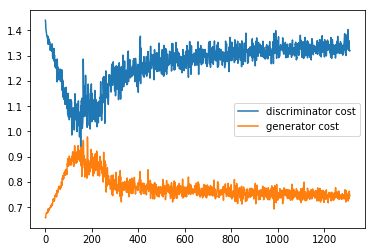

In [12]:
if __name__ == '__main__':
  X, Y = get_mnist()
  X = X.reshape(len(X), 28, 28, 1)
  dim = X.shape[1]
  colors = X.shape[-1]

  # for mnist
  d_sizes = {
    'conv_layers': [(2, 5, 2, False), (64, 5, 2, True)],
    'dense_layers': [(1024, True)],
  }
  g_sizes = {
    'z': 100,
    'projection': 128,
    'bn_after_project': False,
    'conv_layers': [(128, 5, 2, True), (colors, 5, 2, False)],
    'dense_layers': [(1024, True)],
    'output_activation': tf.sigmoid,
  }


  # setup gan
  # note: assume square images, so only need 1 dim
  gan = DCGAN(dim, colors, d_sizes, g_sizes)
  gan.fit(X)
  # samples = gan.sample(1) # just making sure it works

  # plot reconstruction
  counter=0
  while counter<10:
    counter+=1
    i = np.random.choice(len(X))
    x = X[i]
    im = model.predict([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Reconstruction")
    plt.show()